In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
import matplotlib.ticker as tkrimport 
import numpy as np
import pandas as pd
import re
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
YEARS = ['2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']

file_path = "data/OPENDATANC/"

# Open CSV file in pandas
column_selected = ['SECTEUR_CONSO','NOM','SOUS_SECTEUR_CONSO','FAMILLE_PRODUIT','SOUS_FAMILLE','VARIETE',\
                   'CATEGORIE','DEPARTEMENT','CONDITIONNEMENT','COND_UNITE_LIBELLE_COURT','PRIX_RELEVE',\
                    'RAISON_SOCIALE','QUARTIER','COMMUNE','point_geo']
# mise en format catégorie pour réduire la taille
column_cat = ['SECTEUR_CONSO','NOM','SOUS_SECTEUR_CONSO','FAMILLE_PRODUIT','SOUS_FAMILLE','VARIETE',\
                   'CATEGORIE','DEPARTEMENT','COND_UNITE_LIBELLE_COURT',\
                    'RAISON_SOCIALE','QUARTIER','COMMUNE']


dict_df = {}
for year in YEARS:
    print(year)
    file_name = "OPENDATANC_prix_produits_alimentaires_{year}.csv".format(year=year)
    df = pd.read_csv(file_path + file_name, usecols=column_selected) # Only columns selected
    df['ANNEE'] = year
    for col in column_cat:
        df[col] = df[col].astype('category')
    
    dict_df[year]=df

2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


In [3]:
df_raw=pd.concat(dict_df.values())
print(len(df_raw.index),len(df_raw.columns.to_list()),df_raw.columns.to_list())

51869712 16 ['NOM', 'SECTEUR_CONSO', 'SOUS_SECTEUR_CONSO', 'FAMILLE_PRODUIT', 'SOUS_FAMILLE', 'VARIETE', 'CATEGORIE', 'DEPARTEMENT', 'CONDITIONNEMENT', 'COND_UNITE_LIBELLE_COURT', 'PRIX_RELEVE', 'RAISON_SOCIALE', 'QUARTIER', 'COMMUNE', 'point_geo', 'ANNEE']


In [4]:
# Add lat & lon columns from point_geo
df_raw['point_geo'] = df_raw['point_geo'].astype(str)
df_raw[['lat', 'lon']] = df_raw['point_geo'].str.split(',', expand=True)
df_raw.lat = df_raw.lat.astype(float)
df_raw.lon = df_raw.lon.astype(float)
# df_raw = df_raw.drop(columns=['point_geo'])

df_net = df_raw

In [5]:
## Analyse n°1
df_net_dep = df_net[df_net.CATEGORIE != 'SERVICE']

df_rgb_departement = df_net_dep.groupby(['DEPARTEMENT','CATEGORIE']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'))
df_rgb_departement['count_trans_pct'] = df_rgb_departement['count_trans']/df_rgb_departement['count_trans'].sum()*100
df_rgb_departement['sum_trans_pct'] = df_rgb_departement['sum_trans']/df_rgb_departement['sum_trans'].sum()*100

df_level_1 = df_rgb_departement.groupby(level=[0]).sum()
df_level_2 = df_rgb_departement.groupby(level=[0,1]).sum()

# print(df_rgb_departement)

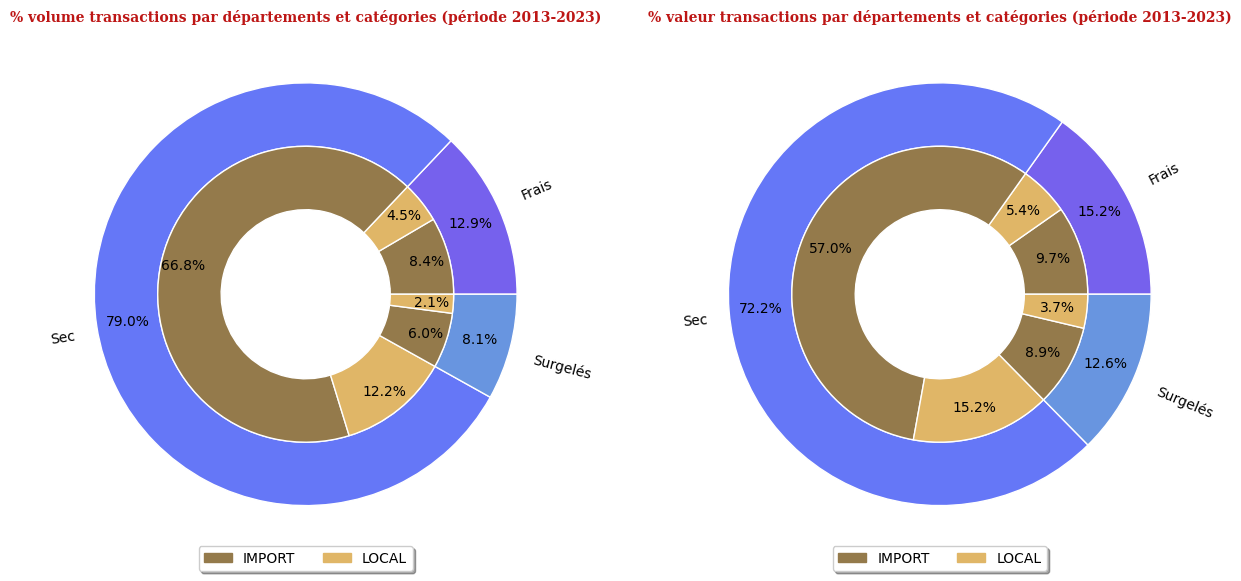

In [6]:
# Graphique n°1
title_family = 'serif'  # 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace'
title_color = '#BD1615' 
title_weight = 'bold' # 'normal' | 'bold' | 'heavy' | 'light' | 'ultrabold' | 'ultralight'
title_size = 10
title_x = 0.5
title_y = 1

fig, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), sharex=True)

## 1
graph_title_1 = "% volume transactions par départements et catégories (période 2013-2023)"

axe1[0].set_title(graph_title_1, x=title_x, y=title_y, fontdict={
               'family': title_family, 'color': title_color, 'weight': title_weight, 'size': title_size})

size = 0.3

outer_colors = ['#7661ED','#6577F7','#6895E0']
inner_colors = ['#947A4B','#E0B667']

inner_labels_1 = df_level_1.index.get_level_values(0)
inner_labels_2 = df_level_2.index.get_level_values(1)

def autopct_tunning(p): return '{:1.1f}%'.format(p) if p > 1 else None

axe1[0].pie(df_level_1['count_trans_pct'], 
            radius=1, 
            labels=inner_labels_1,
            autopct=autopct_tunning,
            colors=outer_colors,
            rotatelabels=True,
            wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85)

axe1[0].pie(df_level_2['count_trans_pct'], 
            radius=1-size, 
            autopct=autopct_tunning,
            colors=inner_colors,
            rotatelabels=True,
            wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85)


# Legend
importation = mpatches.Patch(color='#947A4B', label='IMPORT')
local = mpatches.Patch(color='#E0B667', label='LOCAL')
axe1[0].legend(handles=[importation,local],
               loc="center", 
               bbox_to_anchor=(0, 0, 1, 0),
               ncol=2,
               fancybox=True,
               shadow=True)

## 2
graph_title_2 = "% valeur transactions par départements et catégories (période 2013-2023)"
axe1[1].set_title(graph_title_2, x=title_x, y=title_y, fontdict={
               'family': title_family, 'color': title_color, 'weight': title_weight, 'size': title_size})

size = 0.3

outer_colors = ['#7661ED','#6577F7','#6895E0']
inner_colors = ['#947A4B','#E0B667']

inner_labels_1 = df_level_1.index.get_level_values(0)
inner_labels_2 = df_level_2.index.get_level_values(1)

def autopct_tunning(p): return '{:1.1f}%'.format(p) if p > 1 else None

axe1[1].pie(df_level_1['sum_trans_pct'], 
            radius=1, 
            labels=inner_labels_1,
            autopct=autopct_tunning,
            colors=outer_colors,
            rotatelabels=True,
            wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85)

axe1[1].pie(df_level_2['sum_trans_pct'], 
            radius=1-size, 
            autopct=autopct_tunning,
            colors=inner_colors,
            rotatelabels=True,
            wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.80)


# Legend
importation = mpatches.Patch(color='#947A4B', label='IMPORT')
local = mpatches.Patch(color='#E0B667', label='LOCAL')
axe1[1].legend(handles=[importation,local],
               loc="center", 
               bbox_to_anchor=(0, 0, 1, 0),
               ncol=2,
               fancybox=True,
               shadow=True)

plt.show()

In [7]:
## Analyse n°2
df_rgb_secteur = df_net.groupby(['SECTEUR_CONSO']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'))
df_rgb_secteur['count_trans_pct'] = df_rgb_secteur['count_trans']/df_rgb_secteur['count_trans'].sum()*100
df_rgb_secteur['sum_trans_pct'] = df_rgb_secteur['sum_trans']/df_rgb_secteur['sum_trans'].sum()*100
df_rgb_secteur['avg_trans_pct'] = df_rgb_secteur['sum_trans']/df_rgb_secteur['count_trans']
df_rgb_secteur=df_rgb_secteur.sort_values('count_trans')

# print(df_rgb_secteur)

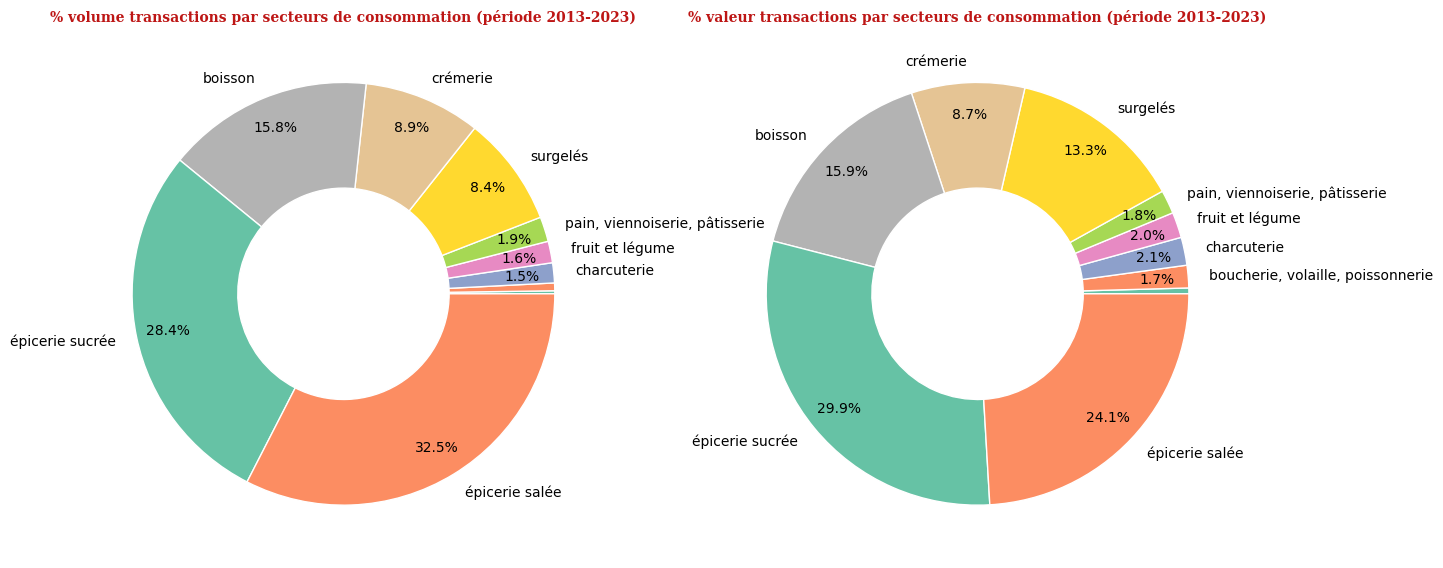

In [8]:
# Graphique n°2.1

title_family = 'serif'  # 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace'
title_color = '#BD1615'  
title_weight = 'bold' # 'normal' | 'bold' | 'heavy' | 'light' | 'ultrabold' | 'ultralight'
title_size = 10
title_x = 0.5
title_y = 1

fig, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), sharex=True)

## 1
graph_title_1 = "% volume transactions par secteurs de consommation (période 2013-2023)"

axe1[0].set_title(graph_title_1, x=title_x, y=title_y, fontdict={
               'family': title_family, 'color': title_color, 'weight': title_weight, 'size': title_size})

size = 0.5

def autopct_tunning(p): return '{:1.1f}%'.format(p) if p > 1 else None

axe1[0].pie(df_rgb_secteur['count_trans_pct'], 
            radius=1, 
            labels=[x if df_rgb_secteur.loc[df_rgb_secteur.index.values == x, 'count_trans_pct'].iloc[0] > 1 else '' for x in df_rgb_secteur.index.values],
            autopct=autopct_tunning,
            colors=sns.color_palette('Set2'),
            wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85)


## 2
graph_title_2 = "% valeur transactions par secteurs de consommation (période 2013-2023)"
axe1[1].set_title(graph_title_2, x=title_x, y=title_y, fontdict={
               'family': title_family, 'color': title_color, 'weight': title_weight, 'size': title_size})

size = 0.5

def autopct_tunning(p): return '{:1.1f}%'.format(p) if p > 1 else None

axe1[1].pie(df_rgb_secteur['sum_trans_pct'], 
            radius=1, 
            labels=[x if df_rgb_secteur.loc[df_rgb_secteur.index.values == x, 'sum_trans_pct'].iloc[0] > 1 else '' for x in df_rgb_secteur.index.values],
            autopct=autopct_tunning,
            colors=sns.color_palette('Set2'),
            wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85)


plt.show()

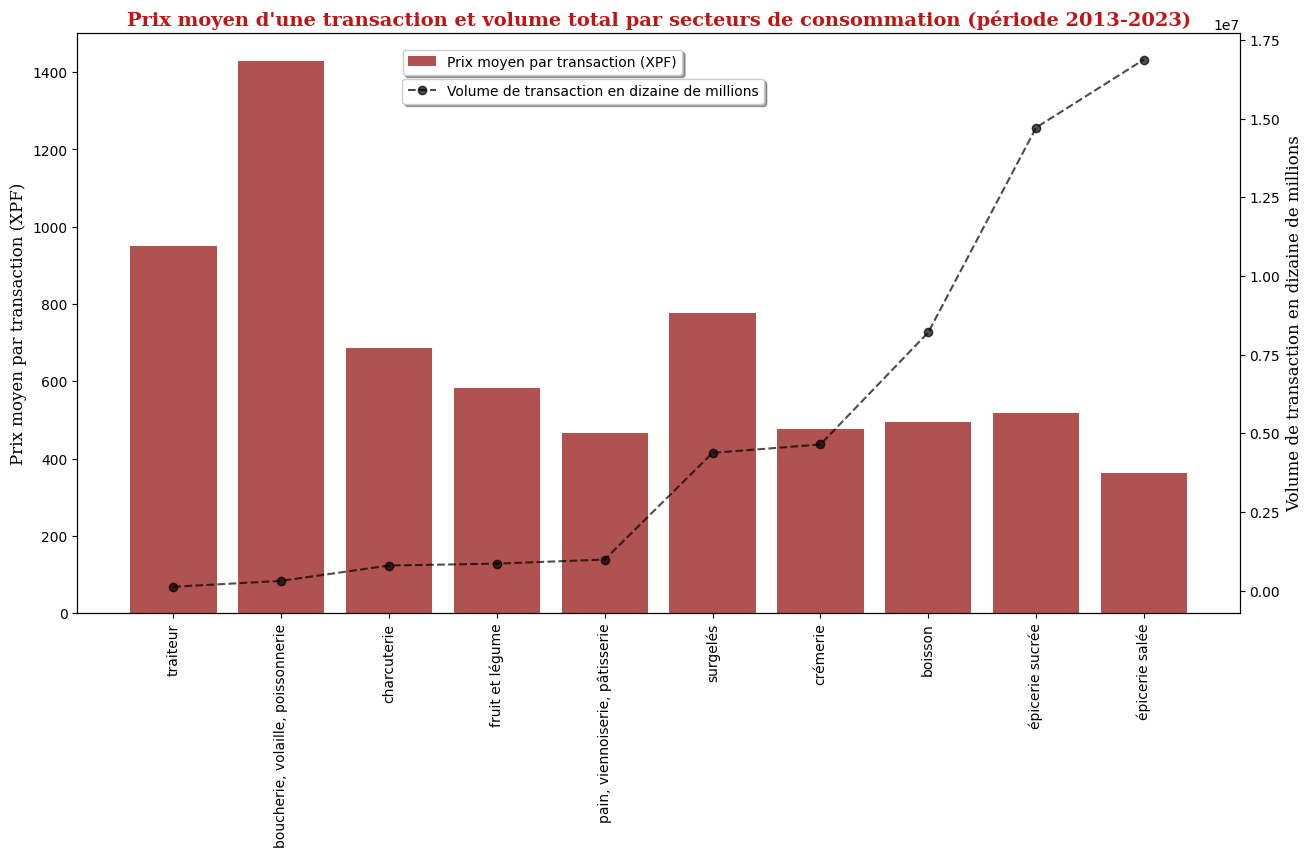

In [9]:
# Graphique 2.2
graph_title = "Prix moyen d'une transaction et volume total par secteurs de consommation (période 2013-2023)"
title_family = 'serif'   # 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace'
title_color = '#BD1615' 
title_weight = 'bold'     # 'normal' | 'bold' | 'heavy' | 'light' | 'ultrabold' | 'ultralight'
title_size = 14
title_x = 0.5
title_y = 1

# Paramètres d'axes
xtick_rotation = 90

xy_label_family = 'serif'
xy_label_color = 'black'
xy_label_weight = 'light'
xy_label_size = 12

y1_color = '#8E0806'
y1_alpha = 0.7
y1_label = 'Prix moyen par transaction (XPF)'

y2_color = 'black'
y2_alpha = 0.7
y2_label = 'Volume de transaction en dizaine de millions'

graph_linestyle = 'solid'

# Paramètres grille
grid_alpha = 0.5

###########################################################################################################
fig, axe1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharex=True)
fig.subplots_adjust(bottom=0.3)

plt.xticks(rotation=xtick_rotation)

# Axe n°1
axe1.set_title(graph_title, x=title_x, y=title_y, fontdict={'family': title_family, 'color': title_color, 'weight': title_weight, 'size': title_size})
axe1.set_ylabel(y1_label, fontdict={'family': xy_label_family, 'color': xy_label_color, 'weight': xy_label_weight, 'size': xy_label_size})
axe1.bar(df_rgb_secteur.index.values, df_rgb_secteur.avg_trans_pct,color=y1_color, alpha=y1_alpha, label=y1_label)
axe1.legend(loc="center", bbox_to_anchor=(0, 0, 0.8, 1.9),ncol=1, fancybox=True, shadow=True)
# axe1.grid(True, alpha=grid_alpha)

# Axe n°2
axe2 = axe1.twinx()
axe2.set_ylabel(y2_label, fontdict={'family': xy_label_family, 'color': xy_label_color, 'weight': xy_label_weight, 'size': xy_label_size})
axe2.plot(df_rgb_secteur.index.values, df_rgb_secteur.count_trans, color=y2_color, alpha=y2_alpha, label=y2_label, linestyle='--', marker='o')
axe2.legend(loc="center", bbox_to_anchor=(0, 0, 0.87, 1.8),ncol=1, fancybox=True, shadow=True)



In [10]:
# Analyse n°3
df_rgb_sous_secteur = df_net.groupby(['SOUS_SECTEUR_CONSO']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_rgb_sous_secteur['count_trans_pct'] = df_rgb_sous_secteur['count_trans']/df_rgb_sous_secteur['count_trans'].sum()*100
df_rgb_sous_secteur['sum_trans_pct'] = df_rgb_sous_secteur['sum_trans']/df_rgb_sous_secteur['sum_trans'].sum()*100

df_rgb_sous_secteur_count_top10=df_rgb_sous_secteur.sort_values('count_trans', ascending=False).head(20)
df_rgb_sous_secteur_sum_top10=df_rgb_sous_secteur.sort_values('sum_trans', ascending=False).head(20)
df_rgb_sous_secteur_avg_top10=df_rgb_sous_secteur.sort_values('avg_trans', ascending=False).head(20)

global_sous_secteur_count_top10 = df_rgb_sous_secteur_count_top10.index.to_list()
global_sous_secteur_sum_top10 = df_rgb_sous_secteur_sum_top10.index.to_list()
global_sous_secteur_avg_top10 = df_rgb_sous_secteur_avg_top10.index.to_list()

In [11]:
df_net_sous_secteur_count_top10 = df_net[df_net['SOUS_SECTEUR_CONSO'].isin(global_sous_secteur_count_top10)]

df_net_sous_secteur_count_top10_i = df_net_sous_secteur_count_top10[df_net_sous_secteur_count_top10['CATEGORIE']=='IMPORT']
df_net_sous_secteur_count_top10_l = df_net_sous_secteur_count_top10[df_net_sous_secteur_count_top10['CATEGORIE']=='LOCAL']

df_net_sous_secteur_count_top10_i = df_net_sous_secteur_count_top10_i.groupby(['SOUS_SECTEUR_CONSO']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_net_sous_secteur_count_top10_i['count_trans_pct'] = df_net_sous_secteur_count_top10_i['count_trans']/df_rgb_sous_secteur['count_trans'].sum()*100
df_net_sous_secteur_count_top10_i['sum_trans_pct'] = df_net_sous_secteur_count_top10_i['sum_trans']/df_rgb_sous_secteur['sum_trans'].sum()*100
df_net_sous_secteur_count_top10_i = df_net_sous_secteur_count_top10_i.loc[global_sous_secteur_count_top10]

df_net_sous_secteur_count_top10_l = df_net_sous_secteur_count_top10_l.groupby(['SOUS_SECTEUR_CONSO']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_net_sous_secteur_count_top10_l['count_trans_pct'] = df_net_sous_secteur_count_top10_l['count_trans']/df_rgb_sous_secteur['count_trans'].sum()*100
df_net_sous_secteur_count_top10_l['sum_trans_pct'] = df_net_sous_secteur_count_top10_l['sum_trans']/df_rgb_sous_secteur['sum_trans'].sum()*100
df_net_sous_secteur_count_top10_l = df_net_sous_secteur_count_top10_l.loc[global_sous_secteur_count_top10]

Text(0, 0.5, 'XPF')

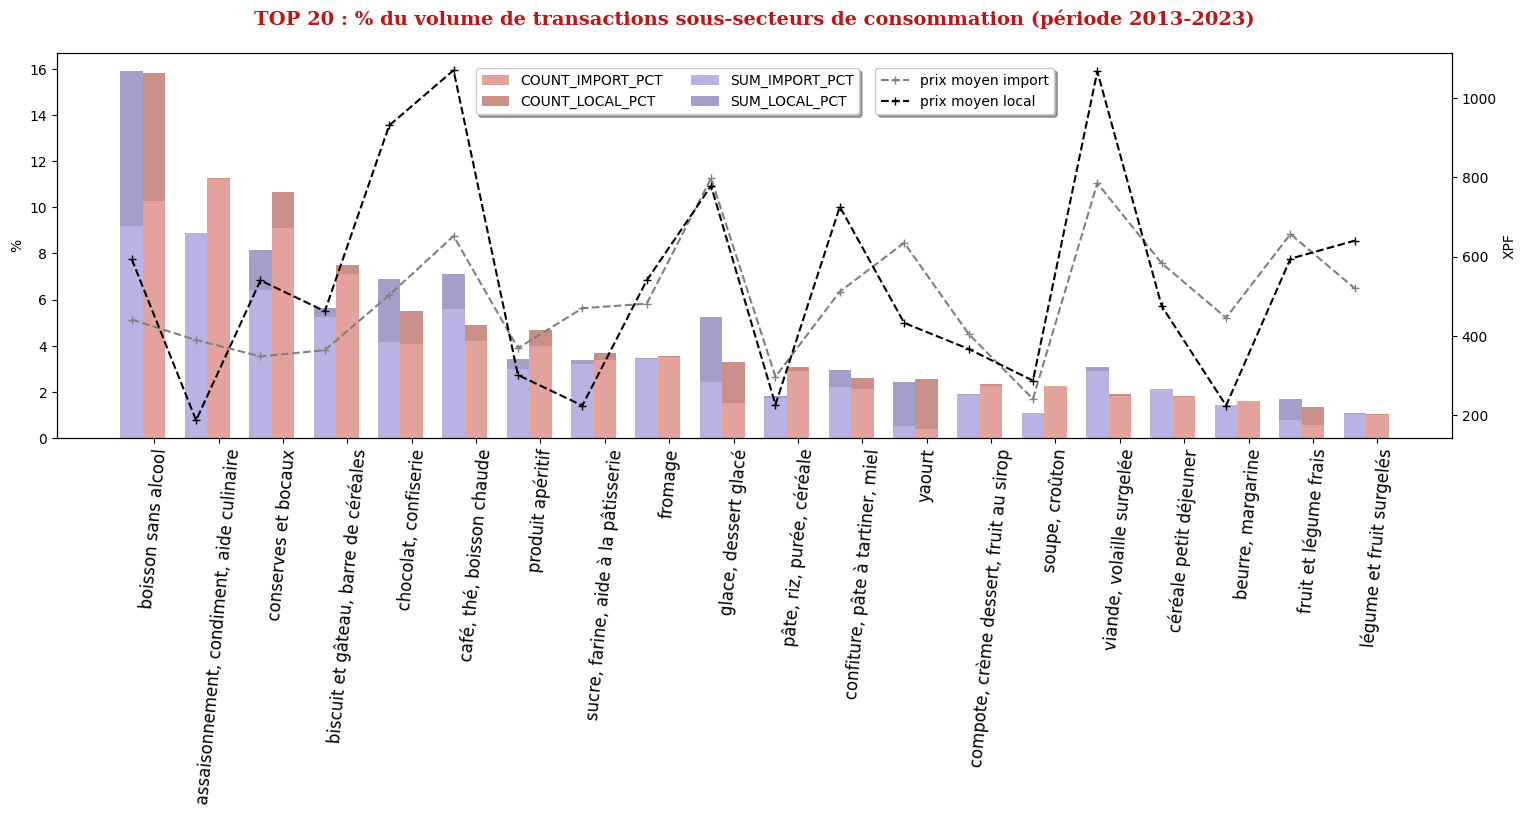

In [12]:
## GRAPHIQUE 3.1
TITLE = "TOP 20 : % du volume de transactions sous-secteurs de consommation (période 2013-2023)"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,5))
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)


width = 0.35
categories = df_net_sous_secteur_count_top10_i.index.to_list()
bar_colors_c = ['#E3A29B', '#C98F89']
bar_colors_s = ['#B8B3E3', '#A39FC9']

count_transaction= {"COUNT_IMPORT_PCT": df_net_sous_secteur_count_top10_i['count_trans_pct'].to_list(),
                    "COUNT_LOCAL_PCT": df_net_sous_secteur_count_top10_l['count_trans_pct'].to_list(),
                   }

sum_transaction= {"SUM_IMPORT_PCT": df_net_sous_secteur_count_top10_i['sum_trans_pct'].to_list(),
                  "SUM_LOCAL_PCT": df_net_sous_secteur_count_top10_l['sum_trans_pct'].to_list(),
                   }


x = np.arange(len(categories))

i=0
bottom_c = np.zeros(len(df_net_sous_secteur_count_top10_i.index.to_list()))
for boolean, pourcentage in count_transaction.items():
    p = ax.bar(x+width, pourcentage, width, label=boolean, bottom=bottom_c, color=bar_colors_c[i])
    bottom_c += pourcentage
    i += 1

j=0
bottom_s = np.zeros(len(df_net_sous_secteur_count_top10_i.index.to_list()))
for boolean, pourcentage in sum_transaction.items():
    p = ax.bar(x, pourcentage, width, label=boolean, bottom=bottom_s, color=bar_colors_s[j])
    bottom_s += pourcentage
    j += 1


ax2 = ax.twinx()
ax2.plot(df_net_sous_secteur_count_top10_i.index.values, df_net_sous_secteur_count_top10_i['avg_trans'], 'grey',linestyle='--', marker='+',linewidth=1.5, label='prix moyen import')
ax2.plot(df_net_sous_secteur_count_top10_l.index.values, df_net_sous_secteur_count_top10_l['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='prix moyen local')


ax.set_ylabel('%')
ax.legend(loc="right",bbox_to_anchor=(0,0,0.58,1.8), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,0.72,1.8), ncol=1, fancybox=True, shadow=True)

ax.set_xticks(x + width, categories)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=85)

ax2.set_ylabel('XPF')

In [13]:
df_net_sous_secteur_sum_top10 = df_net[df_net['SOUS_SECTEUR_CONSO'].isin(global_sous_secteur_sum_top10)]

df_net_sous_secteur_sum_top10_i = df_net_sous_secteur_sum_top10[df_net_sous_secteur_sum_top10['CATEGORIE']=='IMPORT']
df_net_sous_secteur_sum_top10_l = df_net_sous_secteur_sum_top10[df_net_sous_secteur_sum_top10['CATEGORIE']=='LOCAL']

df_net_sous_secteur_sum_top10_i = df_net_sous_secteur_sum_top10_i.groupby(['SOUS_SECTEUR_CONSO']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_net_sous_secteur_sum_top10_i['count_trans_pct'] = df_net_sous_secteur_sum_top10_i['count_trans']/df_rgb_sous_secteur['count_trans'].sum()*100
df_net_sous_secteur_sum_top10_i['sum_trans_pct'] = df_net_sous_secteur_sum_top10_i['sum_trans']/df_rgb_sous_secteur['sum_trans'].sum()*100
df_net_sous_secteur_sum_top10_i = df_net_sous_secteur_sum_top10_i.loc[global_sous_secteur_sum_top10]

df_net_sous_secteur_sum_top10_l = df_net_sous_secteur_sum_top10_l.groupby(['SOUS_SECTEUR_CONSO']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_net_sous_secteur_sum_top10_l['count_trans_pct'] = df_net_sous_secteur_sum_top10_l['count_trans']/df_rgb_sous_secteur['count_trans'].sum()*100
df_net_sous_secteur_sum_top10_l['sum_trans_pct'] = df_net_sous_secteur_sum_top10_l['sum_trans']/df_rgb_sous_secteur['sum_trans'].sum()*100
df_net_sous_secteur_sum_top10_l = df_net_sous_secteur_sum_top10_l.loc[global_sous_secteur_sum_top10]

Text(0, 0.5, 'XPF')

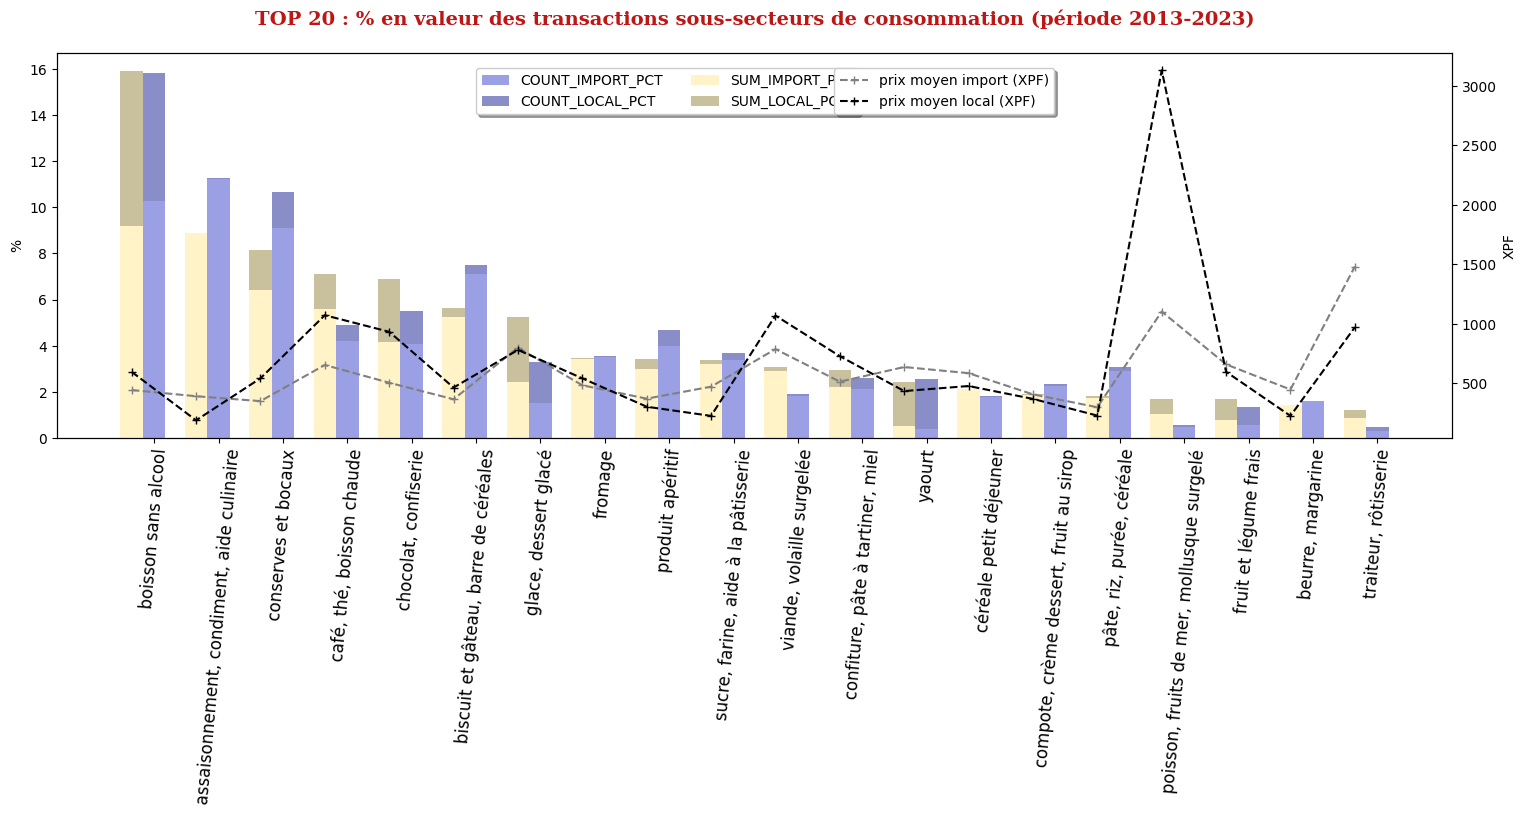

In [14]:
## GRAPHIQUE 4.1
TITLE = "TOP 20 : % en valeur des transactions sous-secteurs de consommation (période 2013-2023)"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,5))
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)


width = 0.35
categories = df_net_sous_secteur_sum_top10_l.index.to_list()
bar_colors_c = ['#9AA0E3', '#898EC9']
bar_colors_s = ['#FFF3C7', '#C9C09D']

count_transaction= {"COUNT_IMPORT_PCT": df_net_sous_secteur_sum_top10_i['count_trans_pct'].to_list(),
                    "COUNT_LOCAL_PCT": df_net_sous_secteur_sum_top10_l['count_trans_pct'].to_list(),
                   }

sum_transaction= {"SUM_IMPORT_PCT": df_net_sous_secteur_sum_top10_i['sum_trans_pct'].to_list(),
                  "SUM_LOCAL_PCT": df_net_sous_secteur_sum_top10_l['sum_trans_pct'].to_list(),
                   }


x = np.arange(len(categories))

i=0
bottom_c = np.zeros(len(df_net_sous_secteur_sum_top10_i.index.to_list()))
for boolean, pourcentage in count_transaction.items():
    p = ax.bar(x+width, pourcentage, width, label=boolean, bottom=bottom_c, color=bar_colors_c[i])
    bottom_c += pourcentage
    i += 1

j=0
bottom_s = np.zeros(len(df_net_sous_secteur_sum_top10_i.index.to_list()))
for boolean, pourcentage in sum_transaction.items():
    p = ax.bar(x, pourcentage, width, label=boolean, bottom=bottom_s, color=bar_colors_s[j])
    bottom_s += pourcentage
    j += 1


ax2 = ax.twinx()
ax2.plot(df_net_sous_secteur_sum_top10_i.index.values, df_net_sous_secteur_sum_top10_i['avg_trans'], 'grey',linestyle='--', marker='+',linewidth=1.5, label='prix moyen import (XPF)')
ax2.plot(df_net_sous_secteur_sum_top10_l.index.values, df_net_sous_secteur_sum_top10_l['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='prix moyen local (XPF)')
# ax2.axhline(0, color='red', alpha=0.2)

ax.set_ylabel('%')

ax.legend(loc="right",bbox_to_anchor=(0,0,0.58,1.8), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,0.72,1.8), ncol=1, fancybox=True, shadow=True)

ax.set_xticks(x + width, categories)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=85)

ax2.set_ylabel('XPF')

In [15]:
# Famille de produit
df_rgb_famille_produit = df_net.groupby(['FAMILLE_PRODUIT']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_rgb_famille_produit['count_trans_pct'] = df_rgb_famille_produit['count_trans']/df_rgb_famille_produit['count_trans'].sum()*100
df_rgb_famille_produit['sum_trans_pct'] = df_rgb_famille_produit['sum_trans']/df_rgb_famille_produit['sum_trans'].sum()*100

df_rgb_famille_produit_count_top10=df_rgb_famille_produit.sort_values('count_trans', ascending=False).head(20)
df_rgb_famille_produit_sum_top10=df_rgb_famille_produit.sort_values('sum_trans', ascending=False).head(20)
df_rgb_famille_produit_avg_top10=df_rgb_famille_produit.sort_values('avg_trans', ascending=False).head(20)

global_famille_produit_count_top10 = df_rgb_famille_produit_count_top10.index.to_list()
global_famille_produit_sum_top10 = df_rgb_famille_produit_sum_top10.index.to_list()
global_famille_produit_avg_top10 = df_rgb_famille_produit_avg_top10.index.to_list()

#  'SOUS_SECTEUR_CONSO', 'FAMILLE_PRODUIT', 'SOUS_FAMILLE', 'VARIETE',

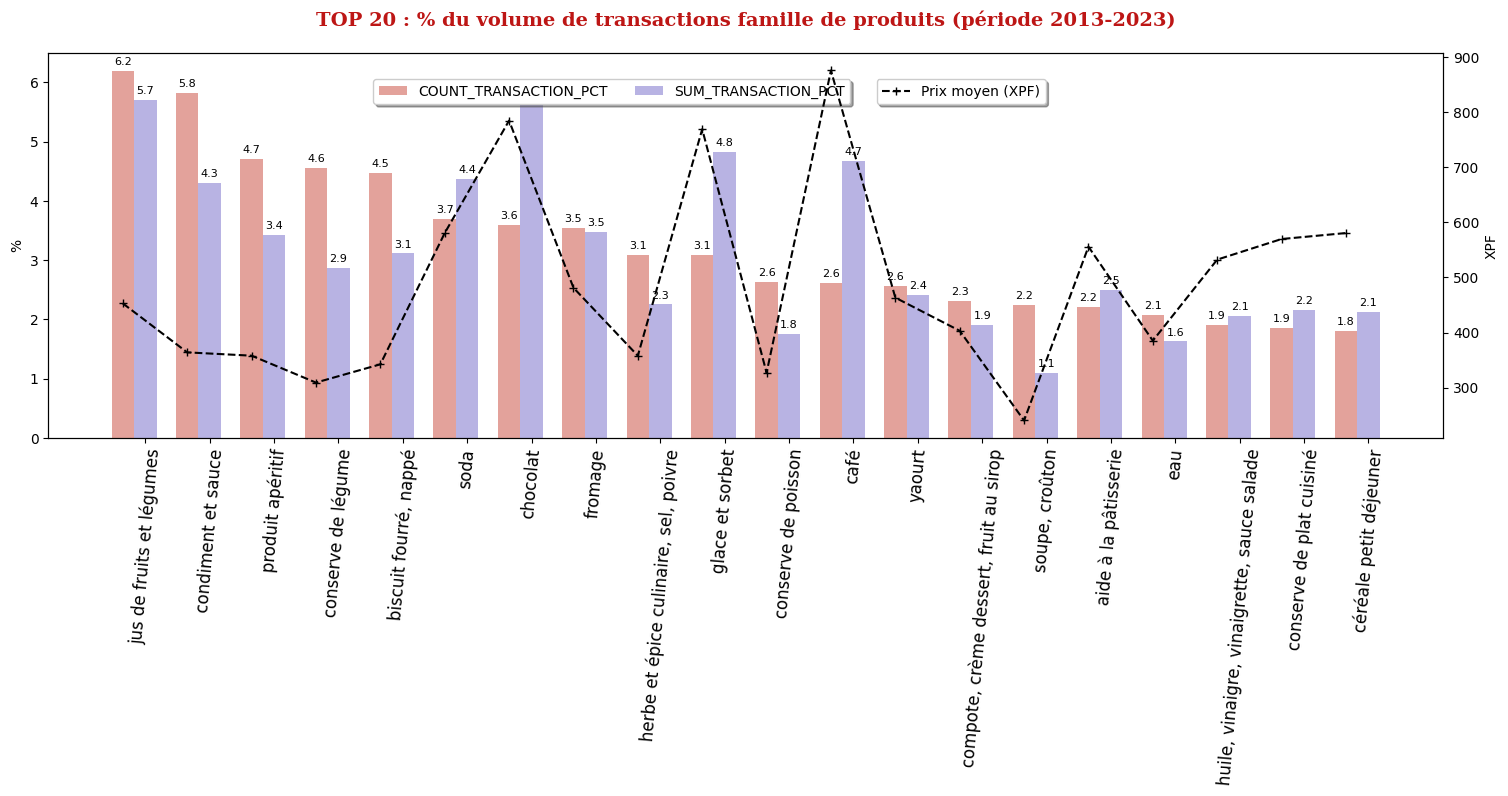

In [16]:
## GRAPHIQUE 3.2
TITLE = "TOP 20 : % du volume de transactions famille de produits (période 2013-2023)"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,5))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)

## 1
categories = df_rgb_famille_produit_count_top10.index.to_list()
value = {'COUNT_TRANSACTION_PCT': df_rgb_famille_produit_count_top10['count_trans_pct'].to_list(),
       'SUM_TRANSACTION_PCT': df_rgb_famille_produit_count_top10['sum_trans_pct'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#E3A29B', '#B8B3E3']

i=0
for attribute, measurement in value.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax.bar_label(rects, padding=3, fontsize=8,fmt='%.1f')
    multiplier += 1
    i+=1

ax2 = ax.twinx()
ax2.plot(df_rgb_famille_produit_count_top10.index.values, df_rgb_famille_produit_count_top10['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='Prix moyen (XPF)')

ax.set_ylabel('%')
ax2.set_ylabel('XPF')

ax.legend(loc="right",bbox_to_anchor=(0,0,0.58,1.8), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,0.72,1.8), ncol=1, fancybox=True, shadow=True)

aw = ax.set_xticks(x + width, categories)
aw = ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=85)

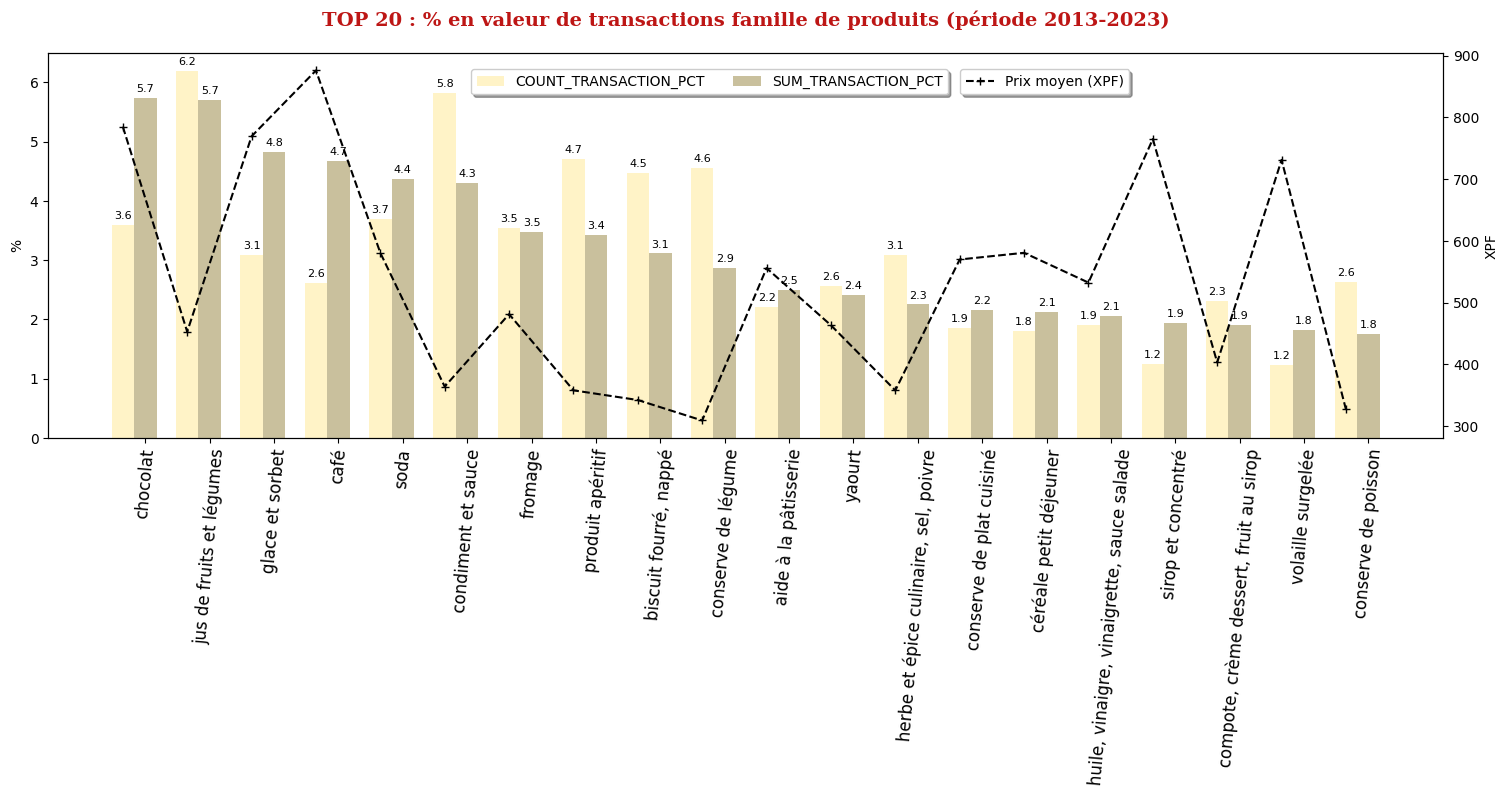

In [17]:
## GRAPHIQUE 4.2
TITLE = "TOP 20 : % en valeur de transactions famille de produits (période 2013-2023)"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,5))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)

## 1
categories = df_rgb_famille_produit_sum_top10.index.to_list()
value = {'COUNT_TRANSACTION_PCT': df_rgb_famille_produit_sum_top10['count_trans_pct'].to_list(),
       'SUM_TRANSACTION_PCT': df_rgb_famille_produit_sum_top10['sum_trans_pct'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#FFF3C7', '#C9C09D']

i=0
for attribute, measurement in value.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax.bar_label(rects, padding=3, fontsize=8,fmt='%.1f')
    multiplier += 1
    i+=1

ax2 = ax.twinx()
ax2.plot(df_rgb_famille_produit_sum_top10.index.values, df_rgb_famille_produit_sum_top10['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='Prix moyen (XPF)')

ax.set_ylabel('%')
ax2.set_ylabel('XPF')

ax.legend(loc="right",bbox_to_anchor=(0,0,0.65,1.85), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,0.78,1.85), ncol=1, fancybox=True, shadow=True)

aw = ax.set_xticks(x + width, categories)
aw = ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=85)

In [18]:
# Sous famille
df_rgb_famille_produit = df_net.groupby(['SOUS_FAMILLE']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_rgb_famille_produit['count_trans_pct'] = df_rgb_famille_produit['count_trans']/df_rgb_famille_produit['count_trans'].sum()*100
df_rgb_famille_produit['sum_trans_pct'] = df_rgb_famille_produit['sum_trans']/df_rgb_famille_produit['sum_trans'].sum()*100

df_rgb_famille_produit_count_top10=df_rgb_famille_produit.sort_values('count_trans', ascending=False).head(20)
df_rgb_famille_produit_sum_top10=df_rgb_famille_produit.sort_values('sum_trans', ascending=False).head(20)
df_rgb_famille_produit_avg_top10=df_rgb_famille_produit.sort_values('avg_trans', ascending=False).head(20)

global_sous_famille_count_top10 = df_rgb_famille_produit_count_top10.index.to_list()
global_sous_famille_sum_top10 = df_rgb_famille_produit_sum_top10.index.to_list()
global_sous_famille_produit_avg_top10 = df_rgb_famille_produit_avg_top10.index.to_list()

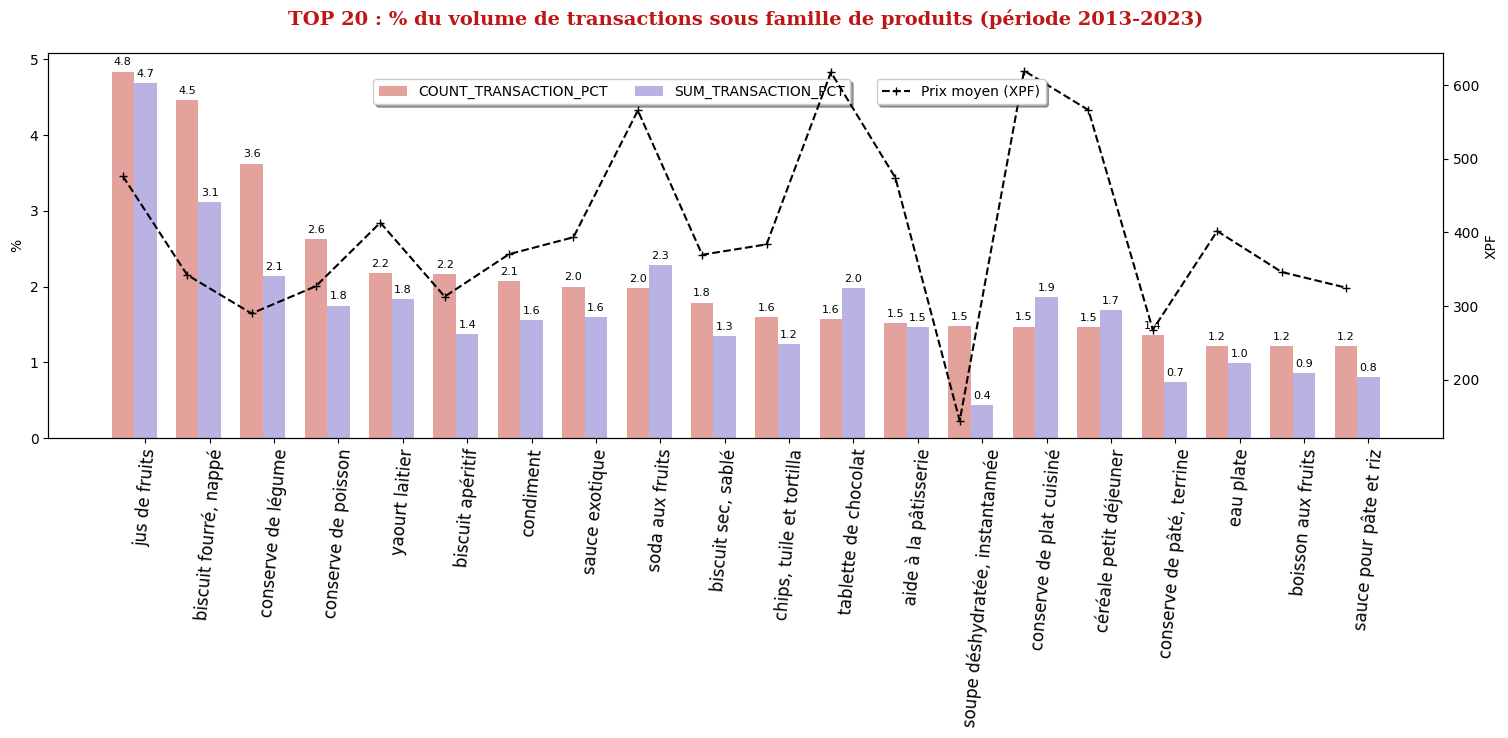

In [19]:
## GRAPHIQUE 3.3
TITLE = "TOP 20 : % du volume de transactions sous famille de produits (période 2013-2023)"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,5))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)

## 1
categories = df_rgb_famille_produit_count_top10.index.to_list()
value = {'COUNT_TRANSACTION_PCT': df_rgb_famille_produit_count_top10['count_trans_pct'].to_list(),
       'SUM_TRANSACTION_PCT': df_rgb_famille_produit_count_top10['sum_trans_pct'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#E3A29B', '#B8B3E3']

i=0
for attribute, measurement in value.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax.bar_label(rects, padding=3, fontsize=8,fmt='%.1f')
    multiplier += 1
    i+=1

ax2 = ax.twinx()
ax2.plot(df_rgb_famille_produit_count_top10.index.values, df_rgb_famille_produit_count_top10['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='Prix moyen (XPF)')

ax.set_ylabel('%')
ax2.set_ylabel('XPF')

ax.legend(loc="right",bbox_to_anchor=(0,0,0.58,1.8), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,0.72,1.8), ncol=1, fancybox=True, shadow=True)

aw = ax.set_xticks(x + width, categories)
aw = ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=85)

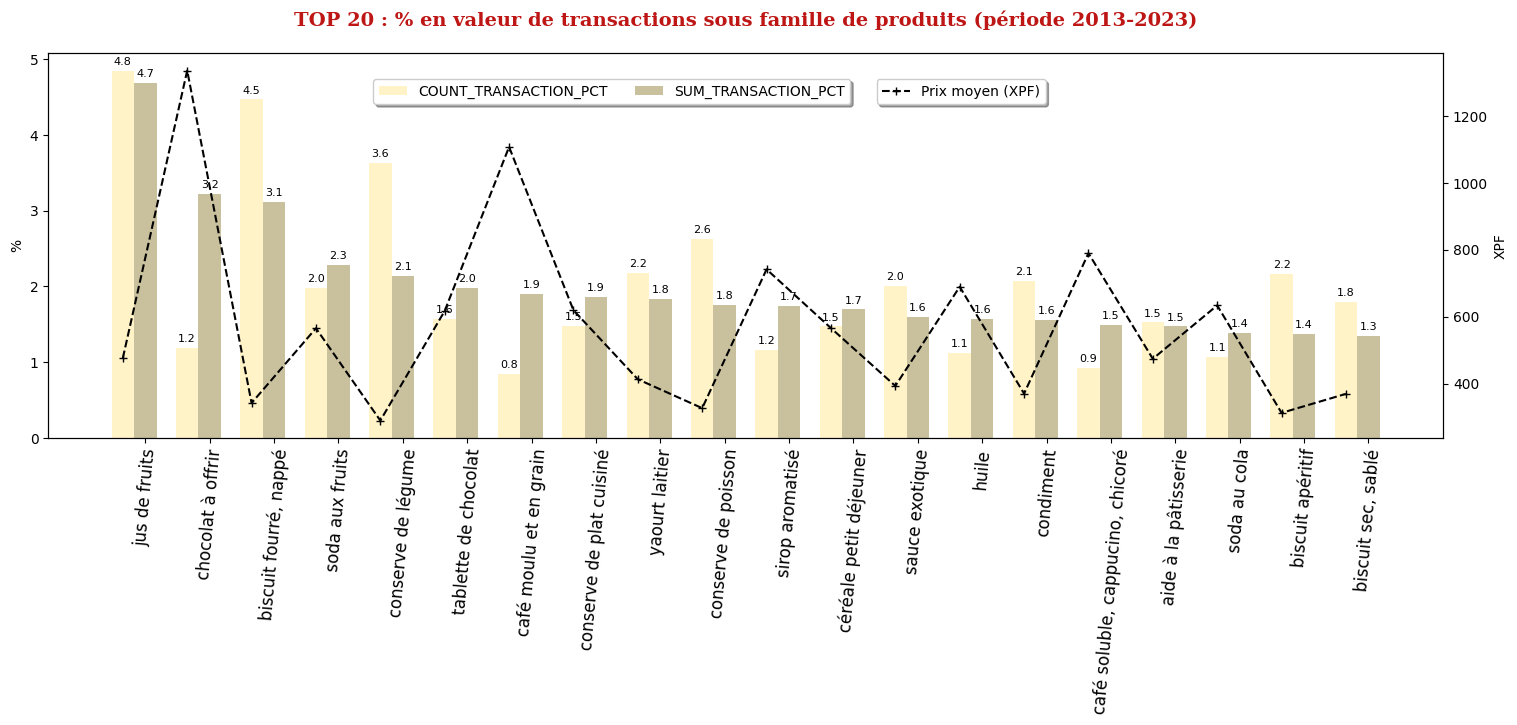

In [20]:
## GRAPHIQUE 4.3
TITLE = "TOP 20 : % en valeur de transactions sous famille de produits (période 2013-2023)"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,5))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)

## 1
categories = df_rgb_famille_produit_sum_top10.index.to_list()
value = {'COUNT_TRANSACTION_PCT': df_rgb_famille_produit_sum_top10['count_trans_pct'].to_list(),
       'SUM_TRANSACTION_PCT': df_rgb_famille_produit_sum_top10['sum_trans_pct'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#FFF3C7', '#C9C09D']

i=0
for attribute, measurement in value.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax.bar_label(rects, padding=3, fontsize=8,fmt='%.1f')
    multiplier += 1
    i+=1

ax2 = ax.twinx()
ax2.plot(df_rgb_famille_produit_sum_top10.index.values, df_rgb_famille_produit_sum_top10['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='Prix moyen (XPF)')

ax.set_ylabel('%')
ax2.set_ylabel('XPF')

ax.legend(loc="right",bbox_to_anchor=(0,0,0.58,1.8), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,0.72,1.8), ncol=1, fancybox=True, shadow=True)

aw = ax.set_xticks(x + width, categories)
aw = ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=85)

In [21]:
# variété 
df_rgb_famille_produit = df_net.groupby(['VARIETE']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_rgb_famille_produit['count_trans_pct'] = df_rgb_famille_produit['count_trans']/df_rgb_famille_produit['count_trans'].sum()*100
df_rgb_famille_produit['sum_trans_pct'] = df_rgb_famille_produit['sum_trans']/df_rgb_famille_produit['sum_trans'].sum()*100

df_rgb_famille_produit_count_top10=df_rgb_famille_produit.sort_values('count_trans', ascending=False).head(20)
df_rgb_famille_produit_sum_top10=df_rgb_famille_produit.sort_values('sum_trans', ascending=False).head(20)
df_rgb_famille_produit_avg_top10=df_rgb_famille_produit.sort_values('avg_trans', ascending=False).head(20)

global_variete_count_top10 = df_rgb_famille_produit_count_top10.index.to_list()
global_variete_sum_top10 = df_rgb_famille_produit_sum_top10.index.to_list()
global_variete_avg_top10 = df_rgb_famille_produit_avg_top10.index.to_list()

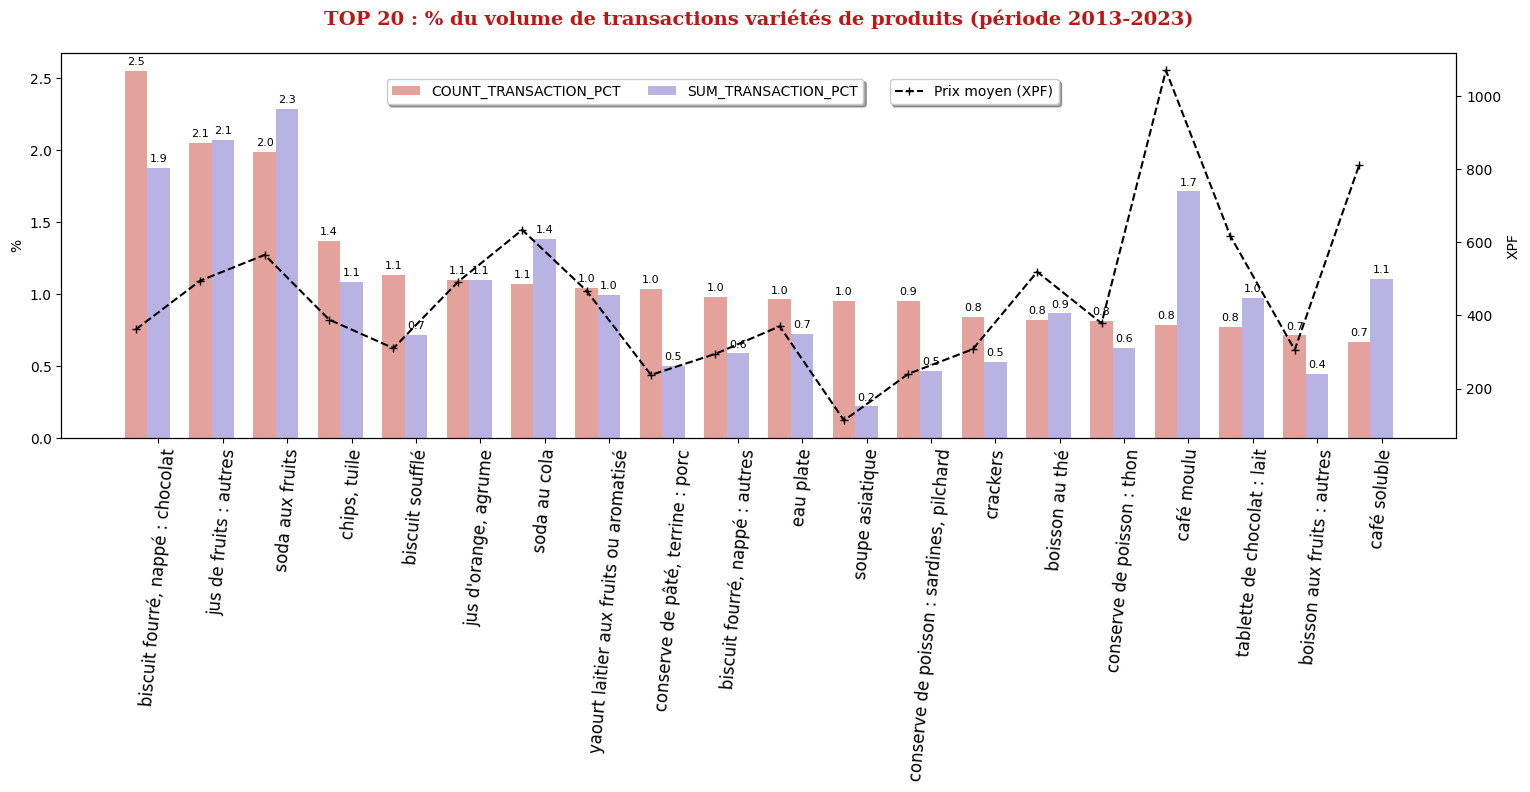

In [22]:
## GRAPHIQUE 3.4
TITLE = "TOP 20 : % du volume de transactions variétés de produits (période 2013-2023)"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,5))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)

## 1
categories = df_rgb_famille_produit_count_top10.index.to_list()
value = {'COUNT_TRANSACTION_PCT': df_rgb_famille_produit_count_top10['count_trans_pct'].to_list(),
       'SUM_TRANSACTION_PCT': df_rgb_famille_produit_count_top10['sum_trans_pct'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#E3A29B', '#B8B3E3']

i=0
for attribute, measurement in value.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax.bar_label(rects, padding=3, fontsize=8,fmt='%.1f')
    multiplier += 1
    i+=1

ax2 = ax.twinx()
ax2.plot(df_rgb_famille_produit_count_top10.index.values, df_rgb_famille_produit_count_top10['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='Prix moyen (XPF)')

ax.set_ylabel('%')
ax2.set_ylabel('XPF')

ax.legend(loc="right",bbox_to_anchor=(0,0,0.58,1.8), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,0.72,1.8), ncol=1, fancybox=True, shadow=True)

aw = ax.set_xticks(x + width, categories)
aw = ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=85)

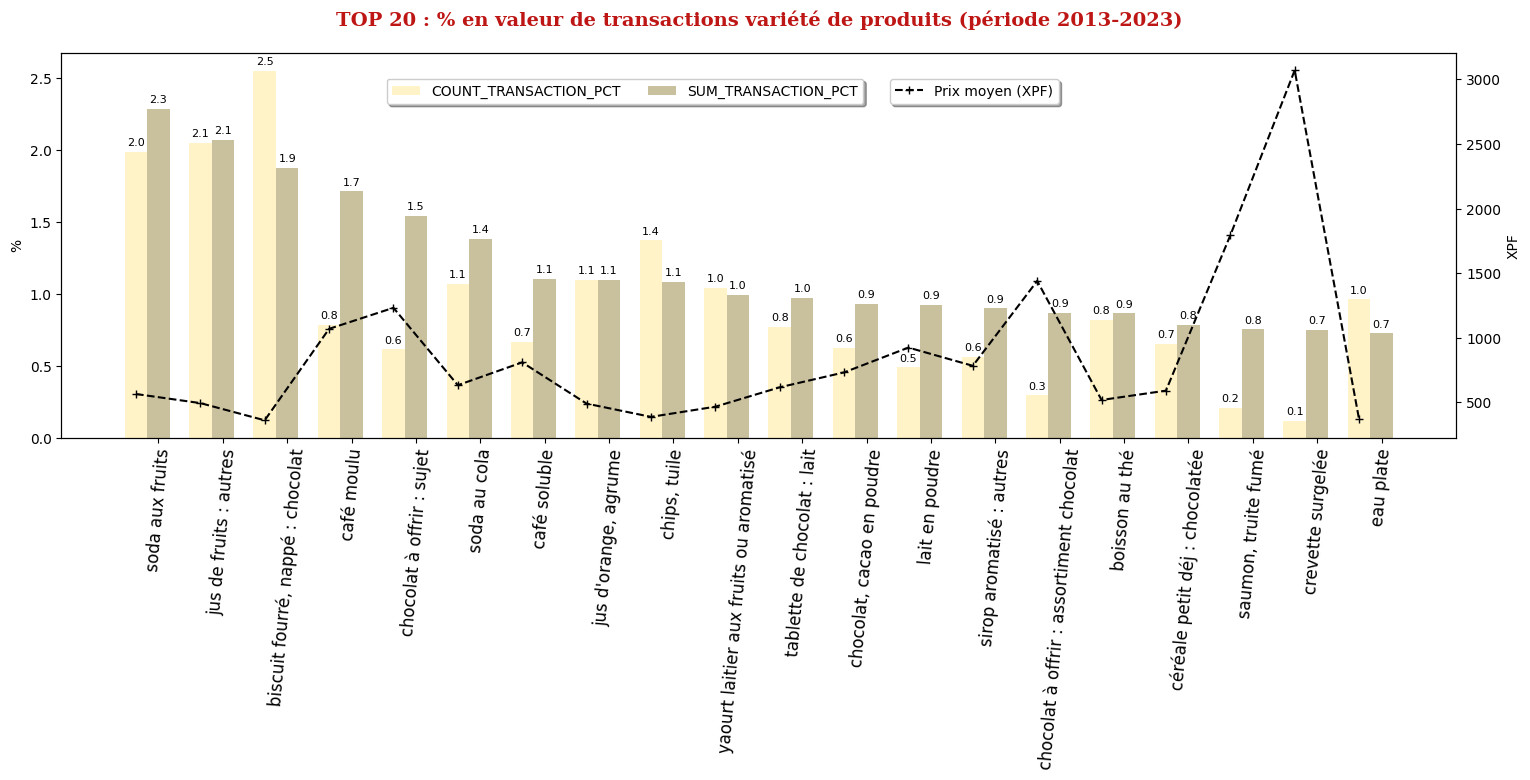

In [23]:
## GRAPHIQUE 4.4
TITLE = "TOP 20 : % en valeur de transactions variété de produits (période 2013-2023)"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,5))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)

## 1
categories = df_rgb_famille_produit_sum_top10.index.to_list()
value = {'COUNT_TRANSACTION_PCT': df_rgb_famille_produit_sum_top10['count_trans_pct'].to_list(),
       'SUM_TRANSACTION_PCT': df_rgb_famille_produit_sum_top10['sum_trans_pct'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#FFF3C7', '#C9C09D']

i=0
for attribute, measurement in value.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax.bar_label(rects, padding=3, fontsize=8,fmt='%.1f')
    multiplier += 1
    i+=1

ax2 = ax.twinx()
ax2.plot(df_rgb_famille_produit_sum_top10.index.values, df_rgb_famille_produit_sum_top10['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='Prix moyen (XPF)')

ax.set_ylabel('%')
ax2.set_ylabel('XPF')

ax.legend(loc="right",bbox_to_anchor=(0,0,0.58,1.8), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,0.72,1.8), ncol=1, fancybox=True, shadow=True)

aw = ax.set_xticks(x + width, categories)
aw = ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=85)

In [24]:
# Produits
df_rgb_produit = df_net.groupby(['NOM']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_rgb_produit['count_trans_pct'] = df_rgb_produit['count_trans']/df_rgb_produit['count_trans'].sum()*100
df_rgb_produit['sum_trans_pct'] = df_rgb_produit['sum_trans']/df_rgb_produit['sum_trans'].sum()*100

df_rgb_produit_count_top10=df_rgb_produit.sort_values('count_trans', ascending=False).head(20)
df_rgb_produit_sum_top10=df_rgb_produit.sort_values('sum_trans', ascending=False).head(20)
df_rgb_produit_avg_top10=df_rgb_produit.sort_values('avg_trans', ascending=False).head(20)

global_count_top10 = df_rgb_produit_count_top10.index.to_list()
global_sum_top10 = df_rgb_produit_sum_top10.index.to_list()
global_avg_top10 = df_rgb_produit_avg_top10.index.to_list()

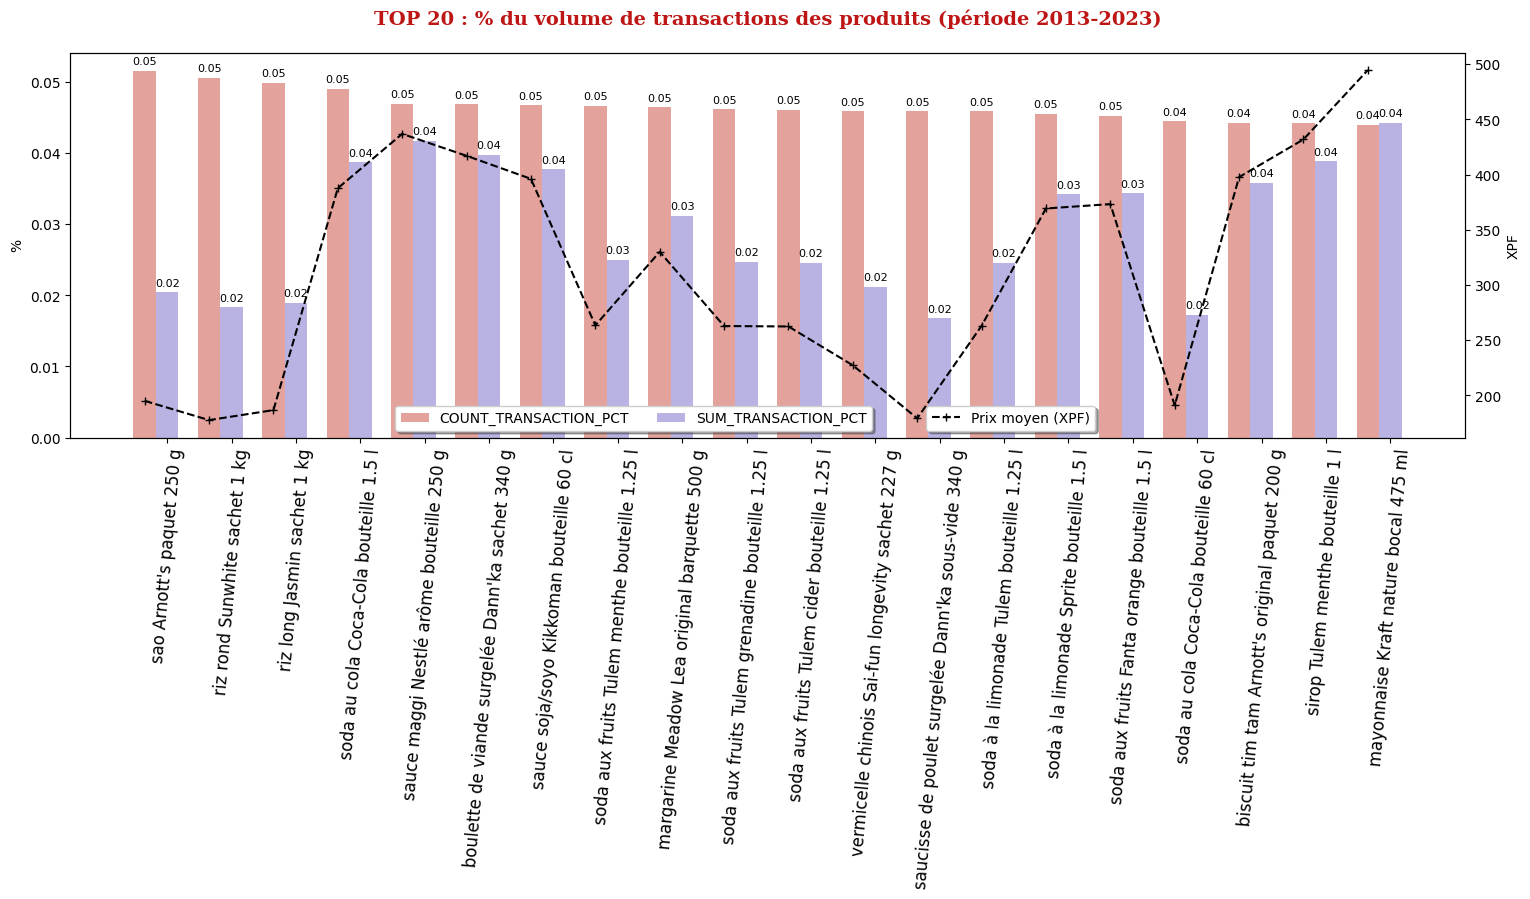

In [25]:
## GRAPHIQUE 3.5
TITLE = "TOP 20 : % du volume de transactions des produits (période 2013-2023)"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,5))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)

## 1
categories = df_rgb_produit_count_top10.index.to_list()
value = {'COUNT_TRANSACTION_PCT': df_rgb_produit_count_top10['count_trans_pct'].to_list(),
       'SUM_TRANSACTION_PCT': df_rgb_produit_count_top10['sum_trans_pct'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#E3A29B', '#B8B3E3']

i=0
for attribute, measurement in value.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax.bar_label(rects, padding=3, fontsize=8,fmt='%.2f')
    multiplier += 1
    i+=1

ax2 = ax.twinx()
ax2.plot(df_rgb_produit_count_top10.index.values, df_rgb_produit_count_top10['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='Prix moyen (XPF)')

ax.set_ylabel('%')
ax2.set_ylabel('XPF')

ax.legend(loc="right",bbox_to_anchor=(0,0,0.58,0.1), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,0.74,0.1), ncol=1, fancybox=True, shadow=True)

aw = ax.set_xticks(x + width, categories)
aw = ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=85)

In [26]:
# Analyse n°5
df_import = df_net[df_net['CATEGORIE']=='IMPORT']
df_local = df_net[df_net['CATEGORIE']=='LOCAL']
df_import_annee = df_import.groupby(['ANNEE']).agg(count_trans_import=('PRIX_RELEVE', 'count'), sum_trans_import=('PRIX_RELEVE', 'sum'))
df_local_annee = df_local.groupby(['ANNEE']).agg(count_trans_local=('PRIX_RELEVE', 'count'), sum_trans_local=('PRIX_RELEVE', 'sum'))
df_categorie = pd.concat([df_import_annee, df_local_annee], axis=1)
df_categorie['PART_COUNT_IMPORT'] = df_categorie['count_trans_import']/(df_categorie['count_trans_import']+df_categorie['count_trans_local'])*100
df_categorie['PART_COUNT_LOCAL'] = df_categorie['count_trans_local']/(df_categorie['count_trans_import']+df_categorie['count_trans_local'])*100

df_categorie['PART_SUM_IMPORT'] = df_categorie['sum_trans_import']/(df_categorie['sum_trans_import']+df_categorie['sum_trans_local'])*100
df_categorie['PART_SUM_LOCAL'] = df_categorie['sum_trans_local']/(df_categorie['sum_trans_import']+df_categorie['sum_trans_local'])*100

df_categorie['TX_COUNT_LOCAL'] = (df_categorie['PART_COUNT_LOCAL']-df_categorie['PART_COUNT_LOCAL'].iloc[0])/df_categorie['PART_COUNT_LOCAL'].iloc[0]*100
df_categorie['TX_COUNT_IMPORT'] = (df_categorie['PART_COUNT_IMPORT']-df_categorie['PART_COUNT_IMPORT'].iloc[0])/df_categorie['PART_COUNT_IMPORT'].iloc[0]*100
df_categorie['TX_SUM_LOCAL'] = (df_categorie['PART_SUM_LOCAL']-df_categorie['PART_SUM_LOCAL'].iloc[0])/df_categorie['PART_SUM_LOCAL'].iloc[0]*100
df_categorie['TX_SUM_IMPORT'] = (df_categorie['PART_SUM_IMPORT']-df_categorie['PART_SUM_IMPORT'].iloc[0])/df_categorie['PART_SUM_IMPORT'].iloc[0]*100
# print(df_categorie)

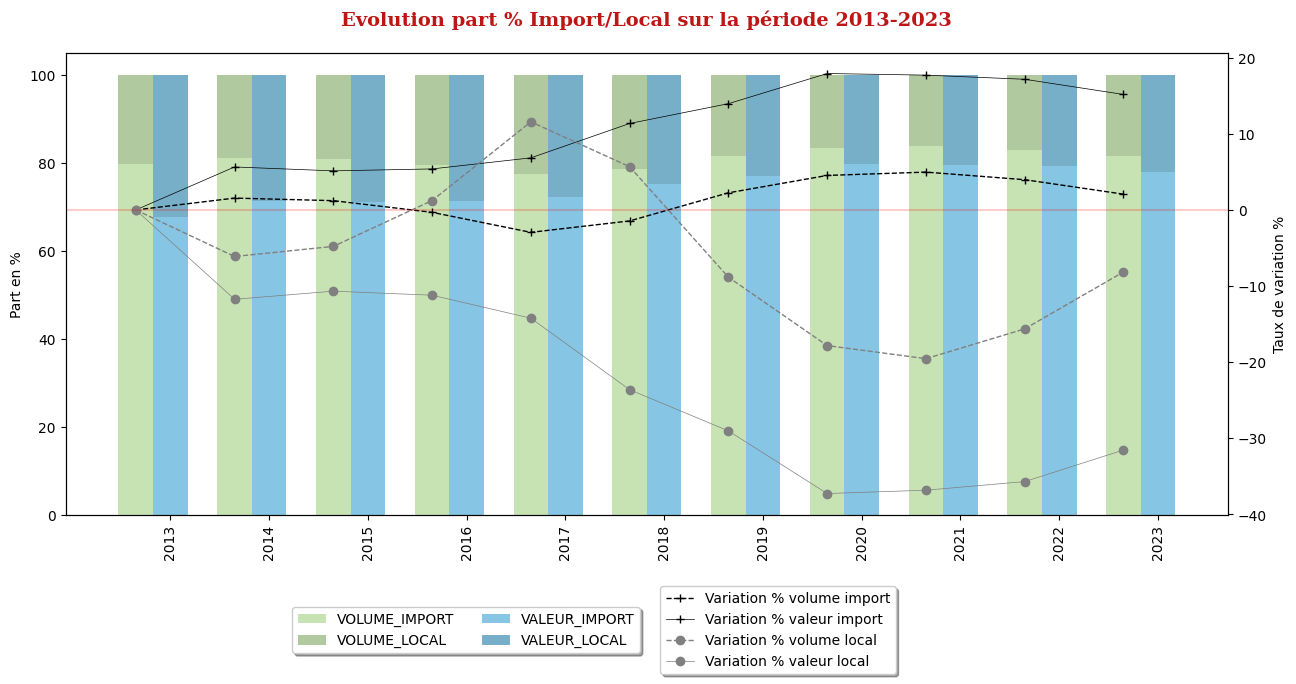

In [27]:
## GRAPHIQUE 5.1
TITLE = "Evolution part % Import/Local sur la période 2013-2023"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)


width = 0.35
categories = df_categorie.index.to_list()
bar_colors_c = ['#C8E3B3', '#B1C99F']
bar_colors_s = ['#86C5E3', '#77AFC9']

count_trans= {"VOLUME_IMPORT": df_categorie['PART_COUNT_IMPORT'].to_list(),
              "VOLUME_LOCAL":  df_categorie['PART_COUNT_LOCAL'].to_list(),
                }

sum_trans= {"VALEUR_IMPORT": df_categorie['PART_SUM_IMPORT'].to_list(),
            "VALEUR_LOCAL": df_categorie['PART_SUM_LOCAL'].to_list(),
                }


x = np.arange(len(categories))

i=0
bottom_c = np.zeros(len(df_categorie.index.to_list()))
for boolean, pourcentage in count_trans.items():
    p = ax.bar(x, pourcentage, width, label=boolean, bottom=bottom_c, color=bar_colors_c[i])
    bottom_c += pourcentage
    i += 1

j=0
bottom_s = np.zeros(len(df_categorie.index.to_list()))
for boolean, pourcentage in sum_trans.items():
    p = ax.bar(x+width, pourcentage, width, label=boolean, bottom=bottom_s, color=bar_colors_s[j])
    bottom_s += pourcentage
    j += 1


ax2 = ax.twinx()
ax2.plot(df_categorie.index.values, df_categorie['TX_COUNT_IMPORT'], 'black',linestyle='--', marker='+',linewidth=1, label='Variation % volume import')
ax2.plot(df_categorie.index.values, df_categorie['TX_SUM_IMPORT'], 'black',linestyle='-', marker='+',linewidth=0.5, label='Variation % valeur import')
ax2.plot(df_categorie.index.values, df_categorie['TX_COUNT_LOCAL'], 'grey',linestyle='--', marker='o',linewidth=1, label='Variation % volume local')
ax2.plot(df_categorie.index.values, df_categorie['TX_SUM_LOCAL'], 'grey',linestyle='-', marker='o',linewidth=0.5, label='Variation % valeur local')
ax2.axhline(0, color='red', alpha=0.2)

ax.set_ylabel('Part en %')
ax2.set_ylabel('Taux de variation %')

ax.set_xticks(x + width, categories)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=90)
ax.legend(loc="right",bbox_to_anchor=(0,0,0.5,-0.5), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,0.72,-0.5), ncol=1, fancybox=True, shadow=True)

In [28]:
# Analyse n°6
df_sous_secteur_count = df_net.groupby(['ANNEE','SECTEUR_CONSO']).agg(count_trans=('PRIX_RELEVE', 'count'))
df_pivot_sous_secteur_count= df_sous_secteur_count.pivot_table(columns='SECTEUR_CONSO', index='ANNEE', values='count_trans')
df_pivot_sous_secteur_count.loc[:,'Total'] = df_pivot_sous_secteur_count.sum(numeric_only=True, axis=1)
df_pivot_sous_secteur_count.iloc[:,:-1] = df_pivot_sous_secteur_count.iloc[:,:-1].div(df_pivot_sous_secteur_count.Total, axis=0)
df_pivot_sous_secteur_count = df_pivot_sous_secteur_count.iloc[:, :].apply(lambda x: x*100)
df_pivot_sous_secteur_count = df_pivot_sous_secteur_count.drop('Total',axis=1)

df_sous_secteur_sum = df_net.groupby(['ANNEE','SECTEUR_CONSO']).agg(count_trans=('PRIX_RELEVE', 'sum'))
df_pivot_sous_secteur_sum= df_sous_secteur_sum.pivot_table(columns='SECTEUR_CONSO', index='ANNEE', values='count_trans')
df_pivot_sous_secteur_sum.loc[:,'Total'] = df_pivot_sous_secteur_sum.sum(numeric_only=True, axis=1)
df_pivot_sous_secteur_sum.iloc[:,:-1] = df_pivot_sous_secteur_sum.iloc[:,:-1].div(df_pivot_sous_secteur_sum.Total, axis=0)
df_pivot_sous_secteur_sum = df_pivot_sous_secteur_sum.iloc[:, :].apply(lambda x: x*100)
df_pivot_sous_secteur_sum = df_pivot_sous_secteur_sum.drop('Total',axis=1)

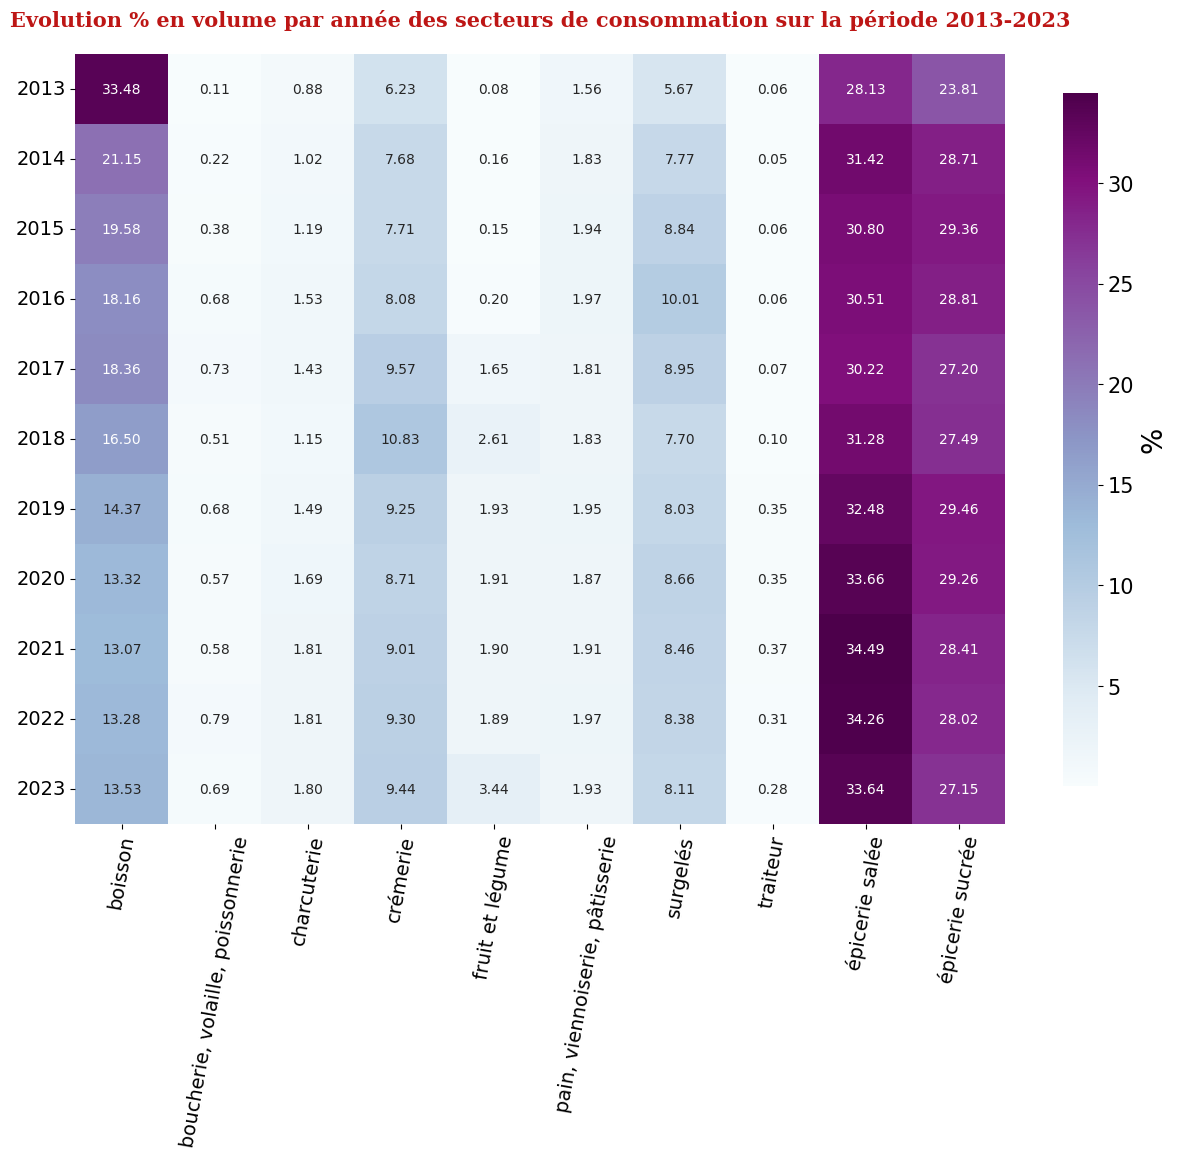

In [29]:
## GRAPHIQUE n°6.1
TITLE = "Evolution % en volume par année des secteurs de consommation sur la période 2013-2023"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 15},pad=20)
ax = sns.heatmap(df_pivot_sous_secteur_count, annot=True, square=False, cmap="BuPu", cbar_kws={'label': '%', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('%', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=80)
ya = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

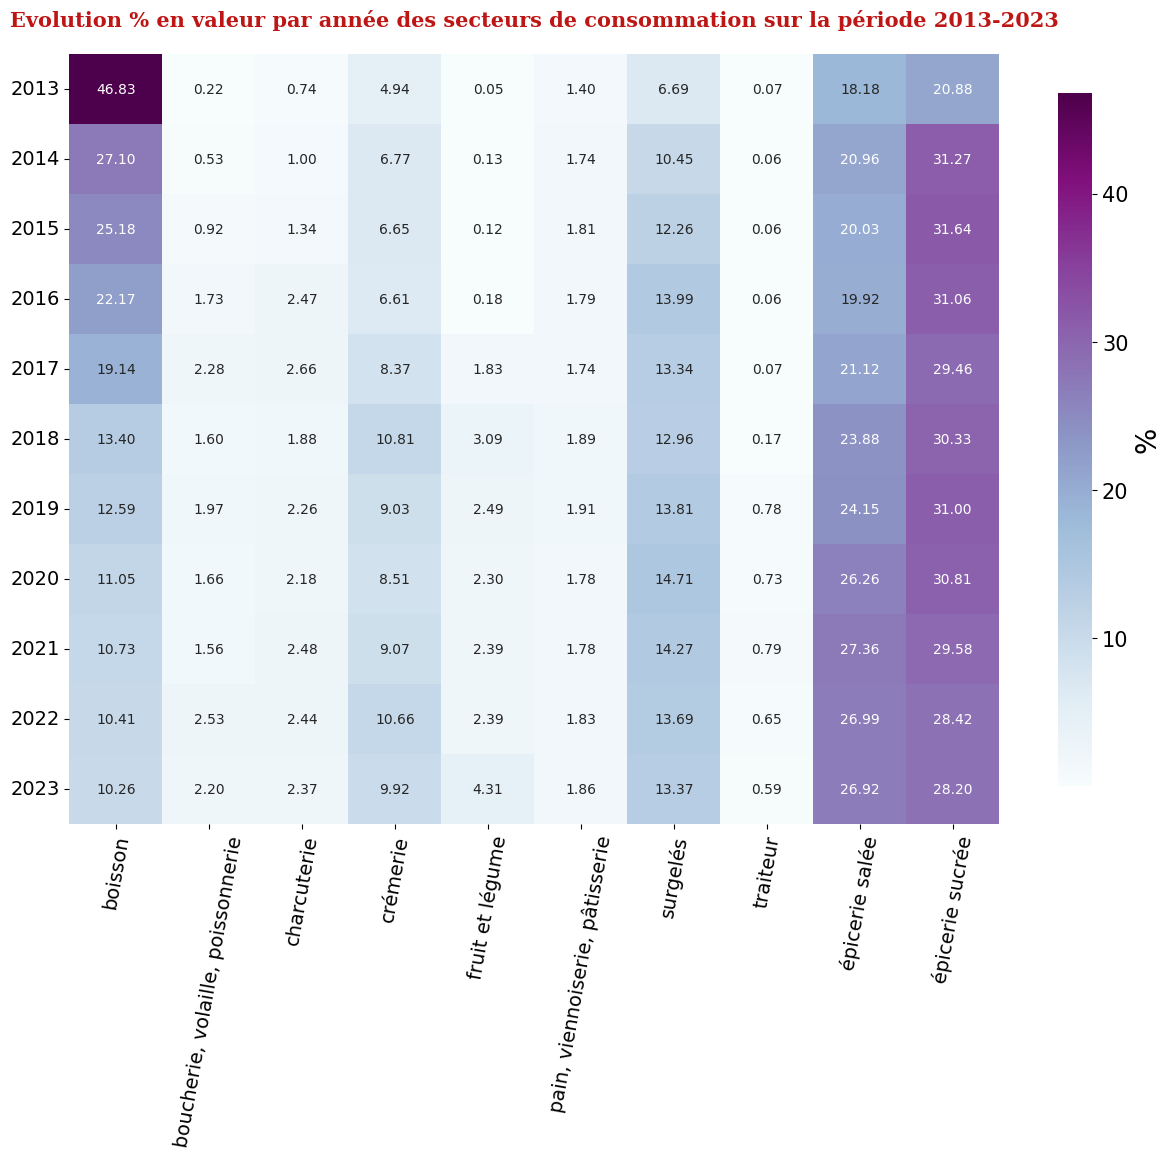

In [30]:
## GRAPHIQUE n°6.2
TITLE = "Evolution % en valeur par année des secteurs de consommation sur la période 2013-2023"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 15},pad=20)
ax = sns.heatmap(df_pivot_sous_secteur_sum, annot=True, square=False, cmap="BuPu", cbar_kws={'label': '%', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('%', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=80)
ya = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

In [31]:
# Analyse n°7
df_year = df_net.groupby(['ANNEE']).agg(count_trans = ('PRIX_RELEVE', 'count'),avg_trans=('PRIX_RELEVE', 'mean'))
df_year['TAUX_VARIATION'] = (df_year['avg_trans']-df_year['avg_trans'].iloc[0])/df_year['avg_trans'].iloc[0]*100
# print(df_year)
df_secteur_year = df_net.groupby(['VARIETE','ANNEE']).agg(avg_trans=('PRIX_RELEVE', 'mean'))
df_secteur_year_pivot = df_secteur_year.pivot_table(columns='VARIETE', index='ANNEE', values='avg_trans')
df_secteur_year_pivot = df_secteur_year_pivot.fillna(method='bfill')
df_secteur_year_pivot = df_secteur_year_pivot.iloc[:, :].apply(lambda x: (x-x.iloc[0])/x.iloc[0]*100)

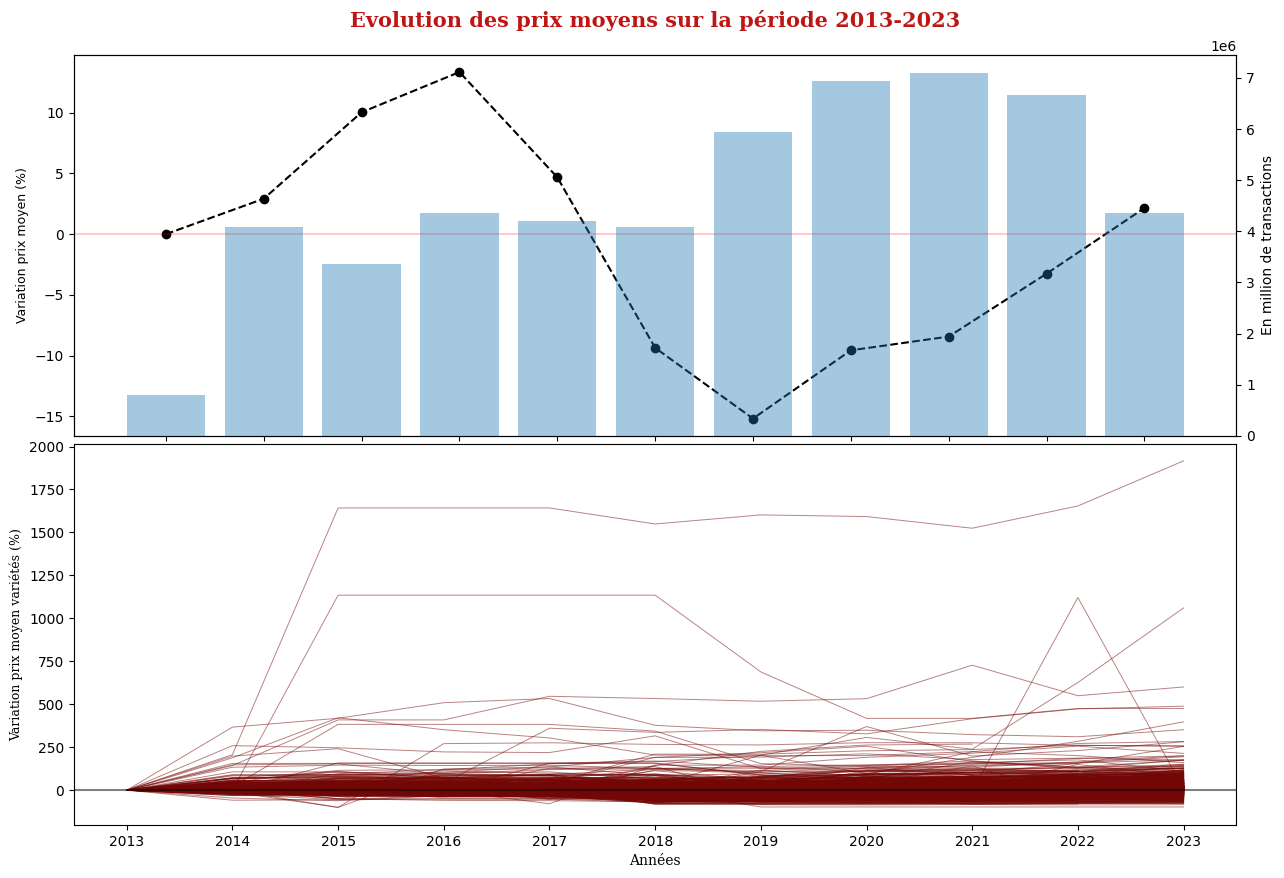

In [32]:
## GRAPHIQUE 7.1
TITLE = "Evolution des prix moyens sur la période 2013-2023" # Titre de la figure

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.02)

# Zone 1
axes[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 15},pad=20)
axes[1].set_xlabel("Années", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axes[1].set_ylabel("Variation prix moyen variétés (%)", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 9})

axes[0].plot(df_year.index.values,df_year['TAUX_VARIATION'],'black',linestyle='--', marker='o',linewidth=1.5,label='Variation moyenne des prix (%)')
axes[0].set_ylabel('Variation prix moyen (%)', size=9)
axes[0].axhline(0, color='red', alpha=0.2)

ax2=axes[0].twinx()
ax2.bar(df_year.index.values, df_year['count_trans'],alpha=0.4)
ax2.set_ylabel('En million de transactions')

i = 0
for alim in df_secteur_year_pivot.columns.to_list():
    axes[1].plot(df_secteur_year_pivot.index.values,df_secteur_year_pivot[alim],color='#730705',linewidth=0.7,alpha=0.5)
    i+=1
axes[1].axhline(0, color='black', alpha=0.5)


In [33]:

df_secteur_year_pivot.loc['Max'] = df_secteur_year_pivot.max()
df_secteur_year_pivot.loc['Min'] = df_secteur_year_pivot.min()
df_max = df_secteur_year_pivot.loc['Max']
df_min = df_secteur_year_pivot.loc['Min']
print(df_max.sort_values(ascending=False).head(11))

VARIETE
agneau : pièce                                 inf
ananas                                 1916.469803
fraise                                 1135.000000
fromage blanc aux fruits, aromatisé    1121.124063
calamar, poulpe, seiche                1060.608126
melon                                   727.577601
barre de céréales                       533.630830
pastèque                                489.062681
autre graisse végétale                  421.539030
fruit exotique : autres                 382.976873
conserve de poisson : crustacé          370.657000
Name: Max, dtype: float64


In [34]:
print(df_min.sort_values(ascending=True).head(11))

VARIETE
veau : pièce                                             -100.000000
bœuf : pièce                                             -100.000000
boisson : autres                                          -97.453993
fromage : tomme                                           -85.732018
beurre : autres                                           -82.470932
gelée : coing                                             -82.023810
conserve de plat cuisiné  : boulette à la sauce tomate    -80.321365
plat surgelé individuel : coquille produit de la mer      -78.865150
bonbon : assortiment                                      -78.846429
plat surgelé à partager : gratin produits de la mer       -78.495298
conserve de pâté, terrine : autres                        -78.405807
Name: Min, dtype: float64


In [35]:
# Analyse n°8
df_raison_sociale = df_net.groupby(['RAISON_SOCIALE']).agg(sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_raison_sociale['PCT_VALEUR'] = df_raison_sociale['sum_trans']/df_raison_sociale['sum_trans'].sum()
df_raison_sociale = df_raison_sociale.sort_values(by='sum_trans', ascending=False)
df_raison_sociale['PCT_VALEUR_CUMSUM']=df_raison_sociale['PCT_VALEUR'].cumsum()
# print(df_raison_sociale)

df_raison_sociale_top = df_raison_sociale.head(20)
global_raison_social = df_raison_sociale_top.index.to_list()
# print(global_raison_social)

In [36]:
sum_valeur_year = df_net.groupby(['ANNEE']).agg(sum_trans=('PRIX_RELEVE', 'sum'))
# print(sum_valeur_year)
df_raison_sociale_topX = df_net[df_net['RAISON_SOCIALE'].isin(global_raison_social)]
df_gb_raison_sociale_topX = df_raison_sociale_topX.groupby(['RAISON_SOCIALE','ANNEE']).agg(sum_trans=('PRIX_RELEVE', 'sum'))
df_pivot_raison_sociale_topX= df_gb_raison_sociale_topX.pivot_table(columns='RAISON_SOCIALE', index='ANNEE', values='sum_trans')
df_pivot_raison_sociale_topX = df_pivot_raison_sociale_topX[df_pivot_raison_sociale_topX.sum().sort_values(ascending = False).index]
df_pivot_raison_sociale_topX_all = pd.concat([df_pivot_raison_sociale_topX, sum_valeur_year], axis=1)
df_pivot_raison_sociale_topX_all.iloc[:,:-1] = df_pivot_raison_sociale_topX_all.iloc[:,:-1].div(df_pivot_raison_sociale_topX_all.sum_trans, axis=0)
df_pivot_raison_sociale_topX_all = df_pivot_raison_sociale_topX_all.iloc[:, :].apply(lambda x: x*100)
df_pivot_raison_sociale_topX_all = df_pivot_raison_sociale_topX_all.drop('sum_trans',axis=1)
# # df_pivot_raison_sociale_topX_final = df_pivot_raison_sociale_topX.divide(df_pivot_raison_sociale_topX, axis=0)
# print(df_pivot_raison_sociale_topX_all)
# # df_pivot_raison_sociale_topX = df_pivot_raison_sociale_topX.iloc[:, :].apply(lambda x: x/total_trans*100)


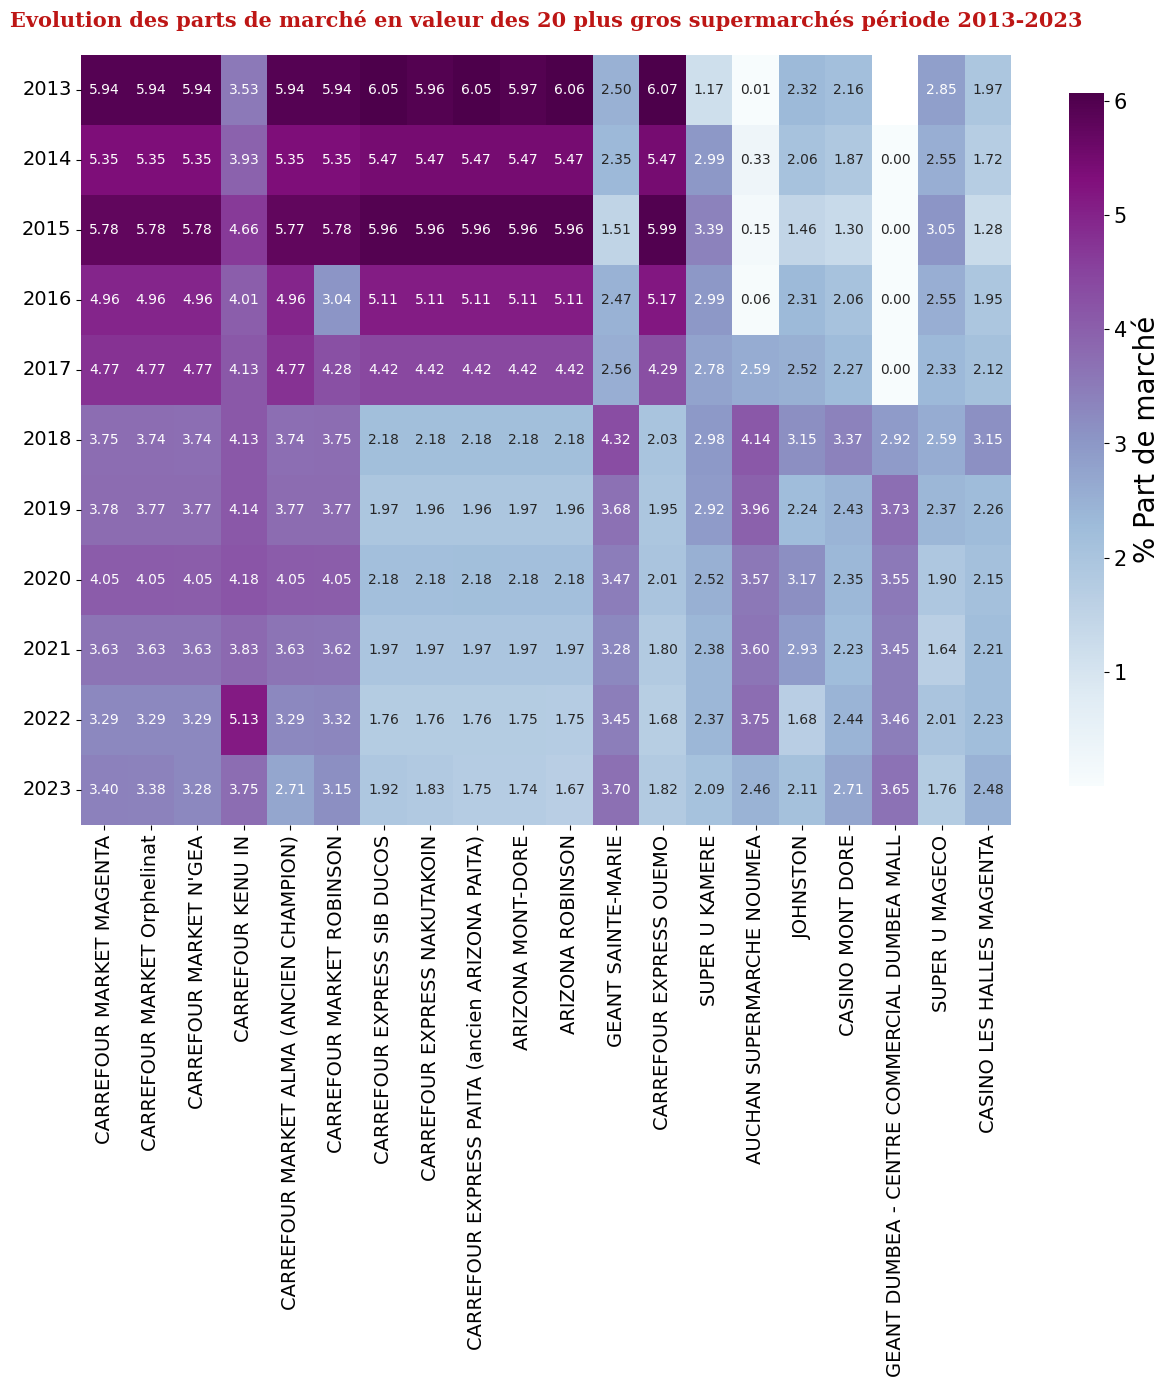

In [37]:
## GRAPHIQUE n°8.1
TITLE = "Evolution des parts de marché en valeur des 20 plus gros supermarchés période 2013-2023"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 15},pad=20)
ax = sns.heatmap(df_pivot_raison_sociale_topX_all, annot=True, square=False, cmap="BuPu", cbar_kws={'label': '%', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('% Part de marché', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90)
ya = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

In [52]:
df_enseigne_top20 = df_net[df_net['RAISON_SOCIALE'].isin(global_raison_social)]
df_gb_enseigne_top20 = df_enseigne_top20.groupby(['RAISON_SOCIALE','ANNEE']).agg(avg_trans=('PRIX_RELEVE', 'mean'))
df_pivot_enseigne_top20= df_gb_enseigne_top20.pivot_table(columns='RAISON_SOCIALE', index='ANNEE', values='avg_trans')
# cols = ["Weight","Height","BootSize","SuitSize","Type"]
# df2[cols] = df2[:].replace({'0':np.nan, 0:np.nan})
# df_pivot_enseigne_top20 = df_pivot_enseigne_top20.iloc[:, :].apply(lambda x: np.nan if x > 722 else x)

# df_pivot_raison_sociale_topX = df_pivot_raison_sociale_topX[df_pivot_raison_sociale_topX.sum().sort_values(ascending = False).index]
# df_pivot_raison_sociale_topX_all = pd.concat([df_pivot_raison_sociale_topX, sum_valeur_year], axis=1)
# df_pivot_raison_sociale_topX_all.iloc[:,:-1] = df_pivot_raison_sociale_topX_all.iloc[:,:-1].div(df_pivot_raison_sociale_topX_all.sum_trans, axis=0)
# 
# df_pivot_raison_sociale_topX_all = df_pivot_raison_sociale_topX_all.drop('sum_trans',axis=1)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

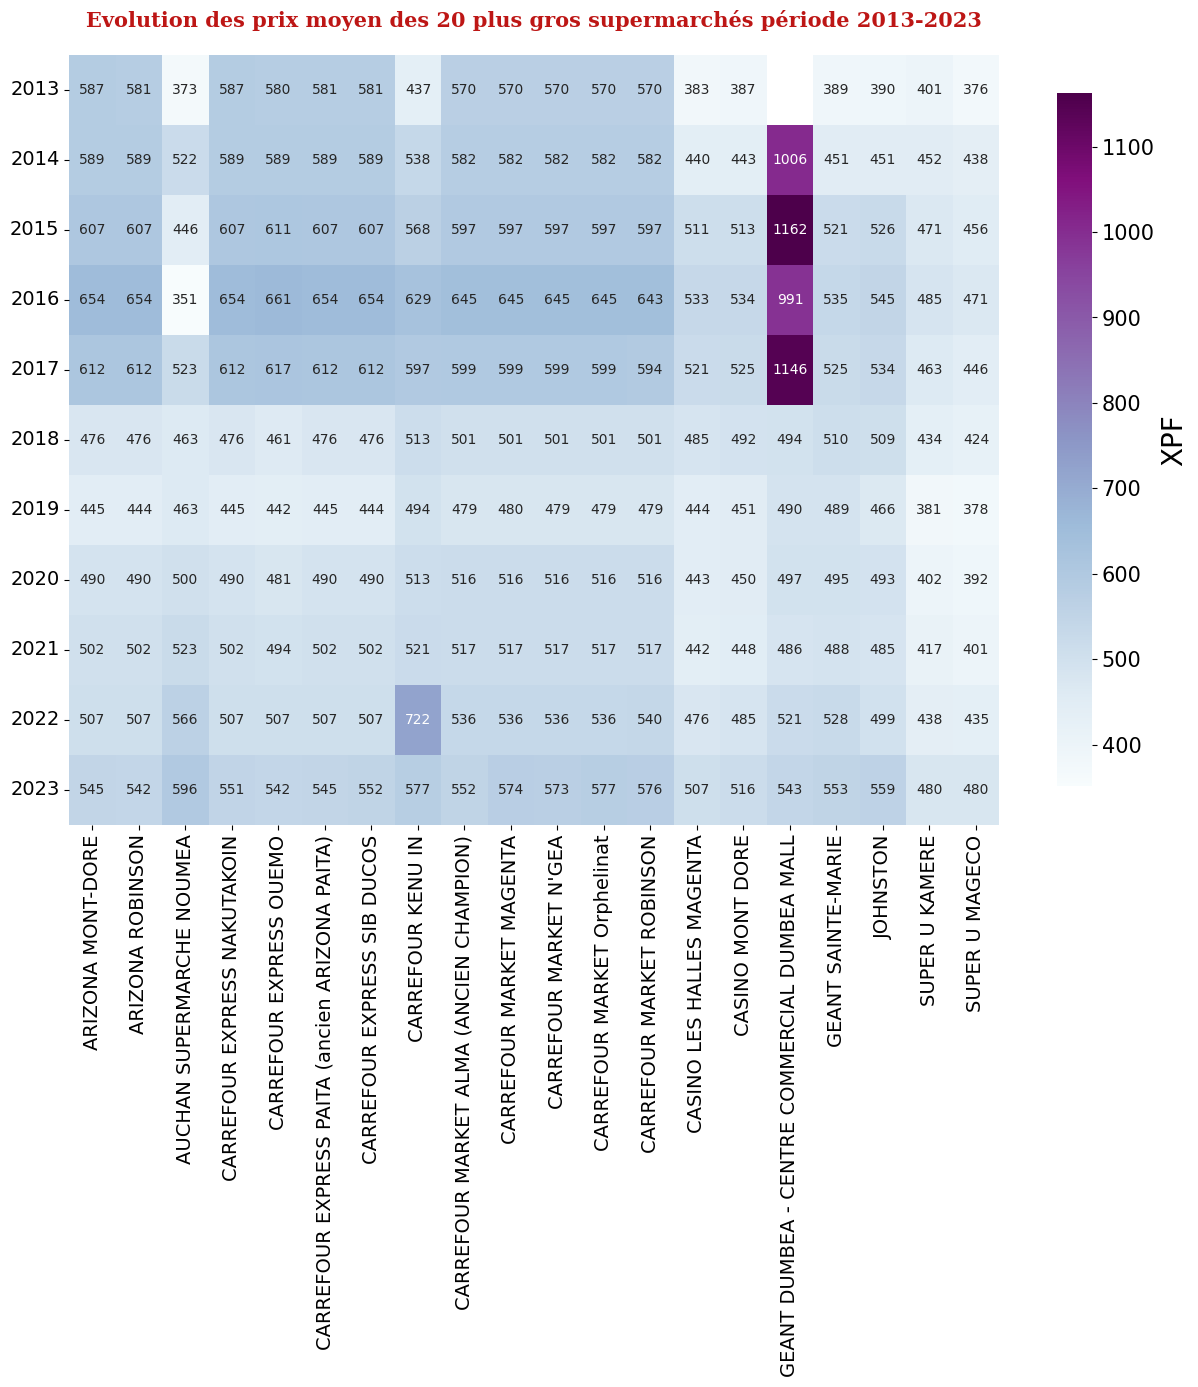

In [50]:
## GRAPHIQUE n°8.2
TITLE = "Evolution des prix moyen des 20 plus gros supermarchés période 2013-2023"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 15},pad=20)
ax = sns.heatmap(df_pivot_enseigne_top20, annot=True, square=False, cmap="BuPu", cbar_kws={'label': '%', 'location' : 'right',"shrink": 0.9} ,fmt='.0f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('XPF', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90)
ya = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

In [40]:
# Analyse n°X - les moins cher par cat
from collections import Counter
df_rs_variete = df_net.groupby(['RAISON_SOCIALE','SECTEUR_CONSO']).agg(avg_trans=('PRIX_RELEVE', 'mean'))
df_pivot_rs_variete = df_rs_variete.pivot_table(columns='RAISON_SOCIALE', index='SECTEUR_CONSO', values='avg_trans')
test = df_pivot_rs_variete.idxmin(axis=1)
# df_rs_variete_cls = pd.DataFrame.from_dict(Counter(test), orient='index').reset_index()
# df_rs_variete_cls = df_rs_variete_cls.rename(columns={'index':'raison_sociale', 0:'count'})
# df_rs_variete_cls = df_rs_variete_cls.sort_values(by='count',ascending=False)
# print(test)

In [41]:
# Analyse n°9
df_rs_commune = df_net.groupby(['COMMUNE']).agg(count_rs=('RAISON_SOCIALE', 'nunique'),lon_rs=('lon', 'mean'),lat_rs=('lat', 'mean'),prix_mean=('PRIX_RELEVE', 'mean'))
# df_rs_commune = df_net.groupby(['COMMUNE','ANNEE']).agg(count_rs=('RAISON_SOCIALE', 'nunique'))
# df_pivot_rs_commune= df_rs_commune.pivot_table(columns='COMMUNE', index='ANNEE', values='count_rs')
print(df_rs_commune)



              count_rs      lon_rs     lat_rs   prix_mean
COMMUNE                                                  
Boulouparis         27  166.056823 -21.872977  406.690196
Bourail             12  165.498232 -21.572618  411.167619
Canala               7  165.962258 -21.518970  372.920214
Dumbéa              54  166.457377 -22.204467  508.114317
Farino               1  165.773338 -21.666801  322.062935
Hienghène            6  164.943773 -20.690480  375.716286
Houailou             6  165.632975 -21.287352  378.818676
Ile Des Pins         7  167.463833 -22.643412  418.284282
Kaala-Gomen          7  164.397317 -20.668318  380.255473
Koné                15  164.873205 -21.077910  439.847235
Kouaoua              5  165.829762 -21.410118  382.884974
Koumac              13  164.284419 -20.558631  443.106310
La Foa               9  165.827738 -21.709798  387.047663
Lifou               21  167.253791 -20.903326  455.948674
Maré                18  167.911401 -21.550562  426.341107
Moindou       

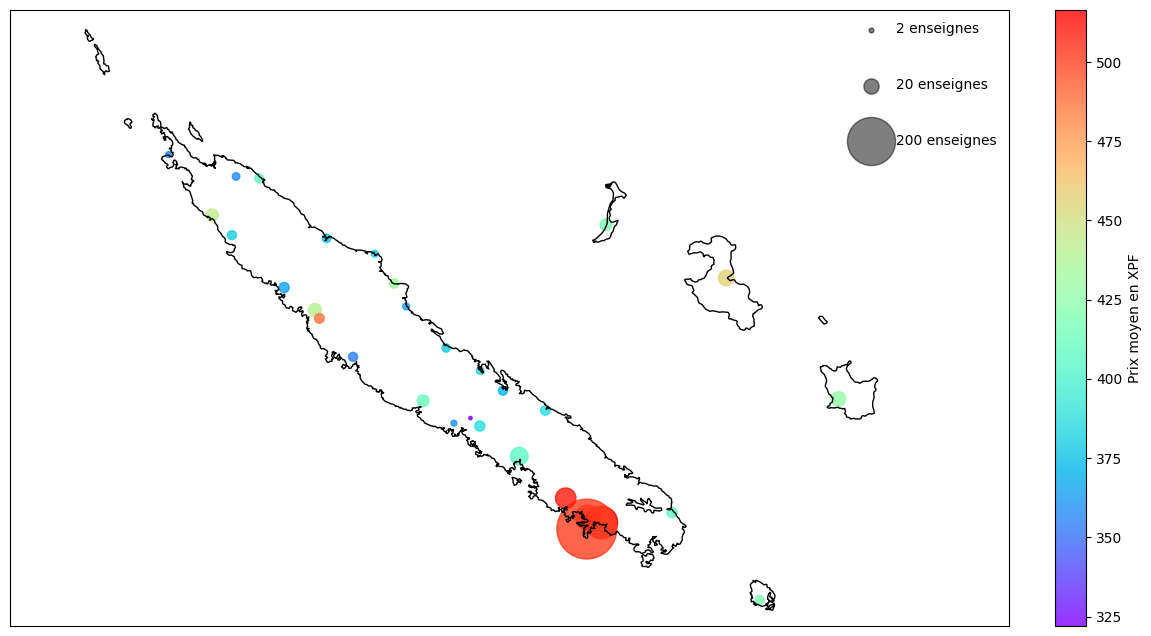

In [42]:
# Graphique 9.1
fig = plt.figure(figsize=(15, 8))

m = Basemap(projection = 'ortho', lon_0 = 166, lat_0 = -24.5,
            llcrnrx=-300000, llcrnry=190000, urcrnrx=300000, urcrnry=560000, 
            resolution = 'h')

m.drawcoastlines(linewidth = 1)
m.drawcountries()

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(df_rs_commune.lon_rs, df_rs_commune.lat_rs, latlon=True,
          c=df_rs_commune.prix_mean, s=df_rs_commune.count_rs*6,
          cmap='rainbow', alpha=0.8)

#np.log10(df_rs_commune.count_rs

# 3. create colorbar and legend
plt.colorbar(label='Prix moyen en XPF',fraction=0.046, pad=0.04)
# plt.clim(3, 7)

# make legend with dummy points
for a in [2, 20, 200]:
    plt.scatter([], [], c='k', alpha=0.5, s=a*6,
                label=str(a) + ' enseignes')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=3, loc='upper right');

In [43]:
prix_moyen_trans = df_net['PRIX_RELEVE'].mean()
df_prix_commune = df_net.groupby(['COMMUNE','ANNEE']).agg(count_rs=('PRIX_RELEVE', 'mean'))
df_pivot_prix_commune= df_prix_commune.pivot_table(columns='COMMUNE', index='ANNEE', values='count_rs')
df_pivot_prix_commune = df_pivot_prix_commune.iloc[:, :].apply(lambda x: (x-prix_moyen_trans)/prix_moyen_trans*100)

# print(df_pivot_prix_commune)

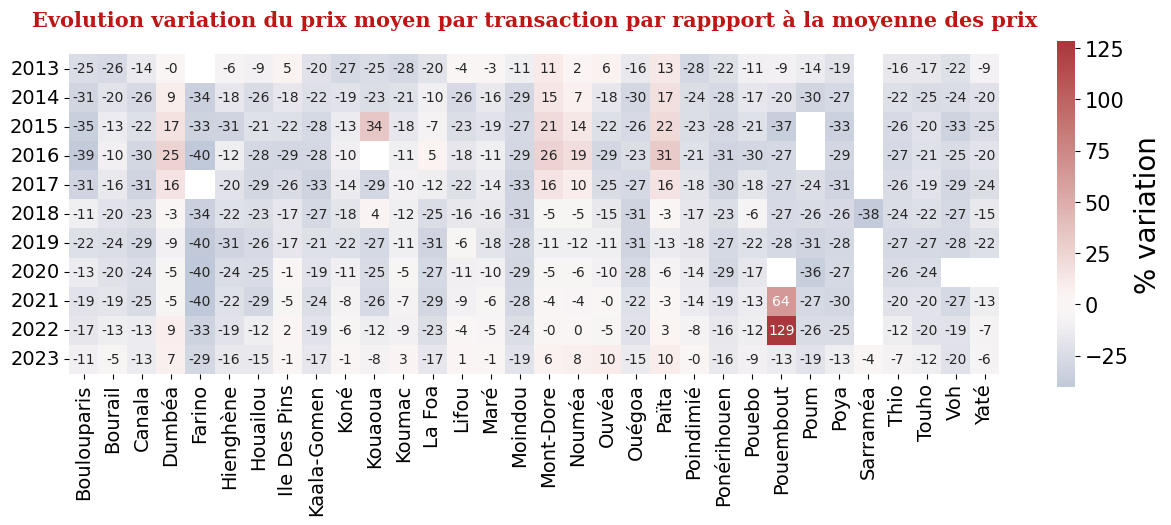

In [44]:
## GRAPHIQUE n°9.2
TITLE = "Evolution variation du prix moyen par transaction par rappport à la moyenne des prix"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 15},pad=20)
ax = sns.heatmap(df_pivot_prix_commune, annot=True, square=True, cmap="vlag", cbar_kws={'label': '%', 'location' : 'right',"shrink": 0.9} ,fmt='.0f',center=0)
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('% variation', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90)
ya = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

In [45]:
df_count_trans_tot = df_net.groupby(['ANNEE']).agg(count_trans_tot=('PRIX_RELEVE', 'count'))

df_prix_commune = df_net.groupby(['COMMUNE','ANNEE']).agg(count_trans_year=('PRIX_RELEVE', 'count'))
df_pivot_prix_commune= df_prix_commune.pivot_table(columns='COMMUNE', index='ANNEE', values='count_trans_year')

df_pivot_prix_commune_all = pd.concat([df_pivot_prix_commune, df_count_trans_tot], axis=1)
df_pivot_prix_commune_all.iloc[:,:-1] = df_pivot_prix_commune_all.iloc[:,:-1].div(df_pivot_prix_commune_all.count_trans_tot, axis=0)
df_pivot_prix_commune_all = df_pivot_prix_commune_all.iloc[:, :].apply(lambda x: x*100)
df_pivot_prix_commune_all = df_pivot_prix_commune_all.drop('count_trans_tot',axis=1)

# print(df_pivot_prix_commune_all)


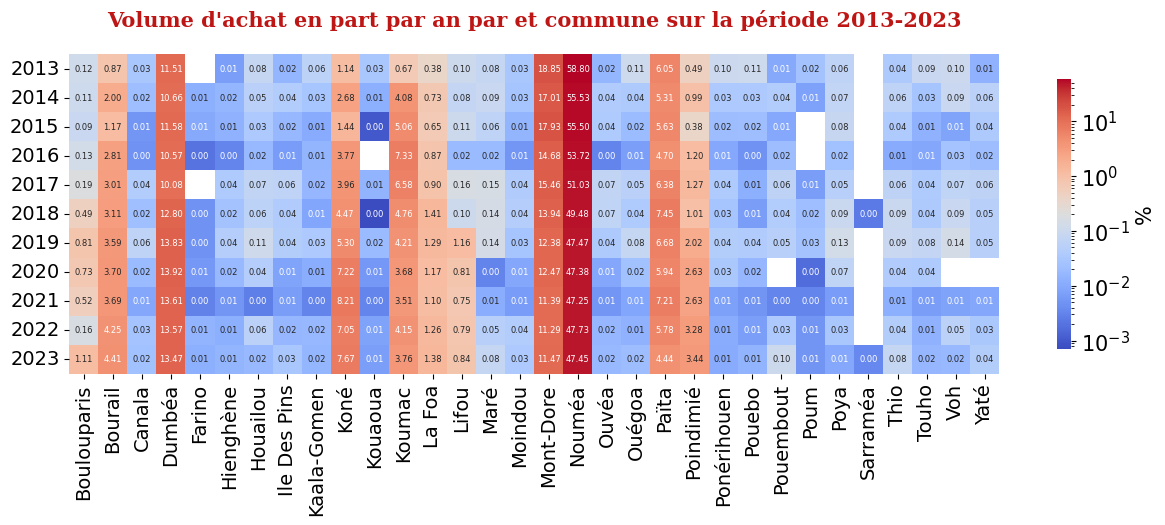

In [46]:
## GRAPHIQUE n°9.3
TITLE = "Volume d'achat en part par an par et commune sur la période 2013-2023"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 15},pad=20)
ax = sns.heatmap(df_pivot_prix_commune_all, annot=True, square=True, cmap="coolwarm", norm=LogNorm(), cbar_kws={'label': '%', 'location' : 'right',"shrink": 0.7}, annot_kws={"fontsize": 6} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('%', size=15)
ax.figure.axes[-1].tick_params(labelsize=15)
xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90)
ya = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)